## 0. Data Import

In [69]:
#uncomment to download required packages
#!pip install -r requirements.txt


In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import scipy.stats as stats
from arch import arch_model
%config InlineBackend.figure_format = 'retina'

In [71]:
tesla_df = pd.read_csv('QRM-2025-cw2-data.csv')
tesla_df['Date'] = pd.to_datetime(tesla_df['Date'])
#compute the log returns in %
tesla_df['log_returns'] = 100*(np.log(tesla_df.TSLA.shift(1)) - np.log(tesla_df.TSLA))
tesla_df['loss'] = -tesla_df.log_returns

In [72]:
tesla_df.head()

Date      TSLA  log_returns      loss
0 2012-11-26  2.151333          NaN       NaN
1 2012-11-27  2.143333     0.372556 -0.372556
2 2012-11-28  2.215333    -3.304064  3.304064
3 2012-11-29  2.246000    -1.374813  1.374813
4 2012-11-30  2.254667    -0.385143  0.385143

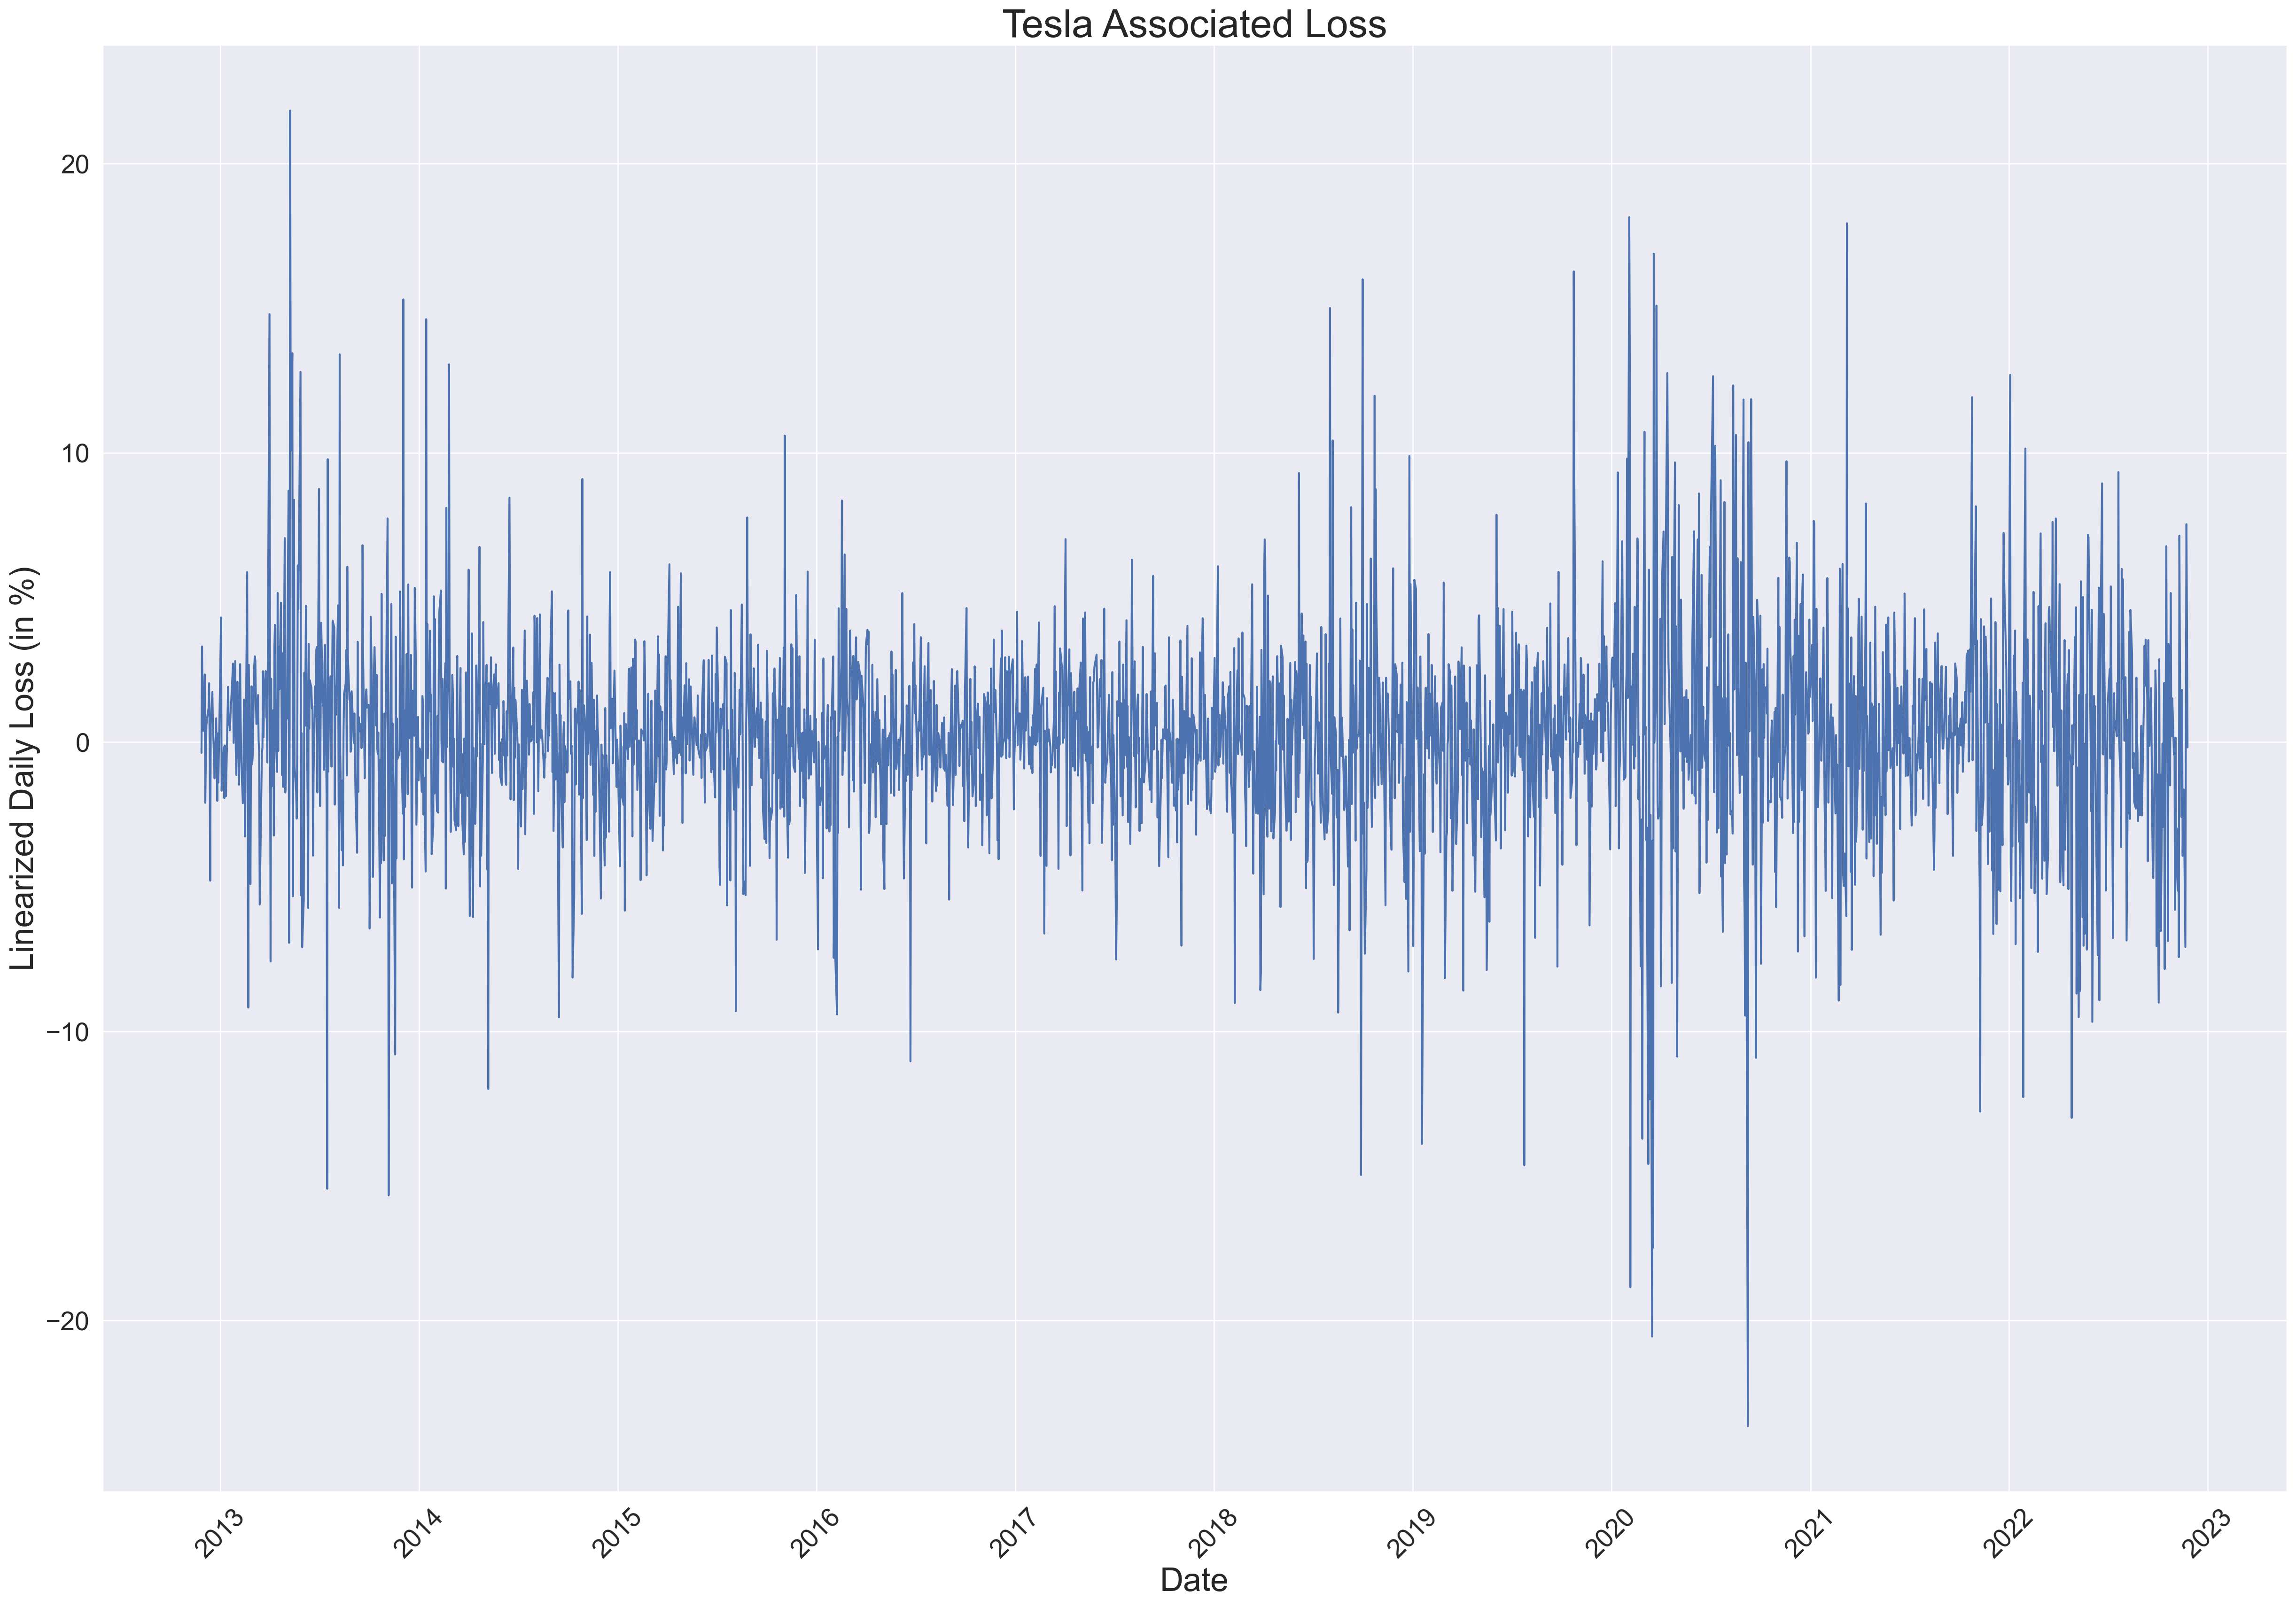

In [73]:
sns.set_theme()
plt.figure(figsize=(30, 20))
sns.lineplot(data=tesla_df, x='Date', y='loss', )
ax = plt.gca()
locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.tick_params(axis='x', labelsize=20, labelrotation=45) # Pour l'axe X, avec une rotation
ax.tick_params(axis='y', labelsize=20) # Pour l'axe Y
plt.title("Tesla Associated Loss", fontsize=30)
plt.ylabel("Linearized Daily Loss (in %)", fontsize=25)
plt.xlabel("Date", fontsize=25)

plt.show()

--- 
## 1. Modeling on Training Data only 

In [74]:
train_df = tesla_df.loc[tesla_df.Date<'2021-11-26',:].dropna()
test_df = tesla_df.loc[tesla_df.Date>'2021-11-26',:].dropna()

### Fit a GARCH(1,1) model to the loss

In [75]:
GARCH = arch_model(train_df['loss'], mean='Constant', vol='GARCH', p=1, q=1, dist='normal')
res = GARCH.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 109977.43472223838
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7646.948143837401
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5878.970834915617
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5902.87203617076
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5882.501525208385
Iteration:      6,   Func. Count:     38,   Neg. LLF: 5864.248120761451
Iteration:      7,   Func. Count:     44,   Neg. LLF: 5926.7993379015425
Iteration:      8,   Func. Count:     51,   Neg. LLF: 5896.344203611621
Iteration:      9,   Func. Count:     57,   Neg. LLF: 5854.909254442988
Iteration:     10,   Func. Count:     62,   Neg. LLF: 5854.909119616166
Iteration:     11,   Func. Count:     67,   Neg. LLF: 5854.909118900442
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5854.909118900442
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 1

In [76]:
res

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   loss   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5854.91
Distribution:                  Normal   AIC:                           11717.8
Method:            Maximum Likelihood   BIC:                           11740.7
                                        No. Observations:                 2266
Date:                Tue, Dec 02 2025   Df Residuals:                     2265
Time:                        19:25:29   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1506  6.416e-02      2.347  1.891e-02 [2.485e-0

In [77]:
res.std_resid

1      -0.285321
2       1.725954
3       0.635442
4       0.121604
5       1.142008
          ...   
2262    0.130877
2263    0.891654
2264    0.404564
2265   -1.143070
2266    0.123682
Name: std_resid, Length: 2266, dtype: float64

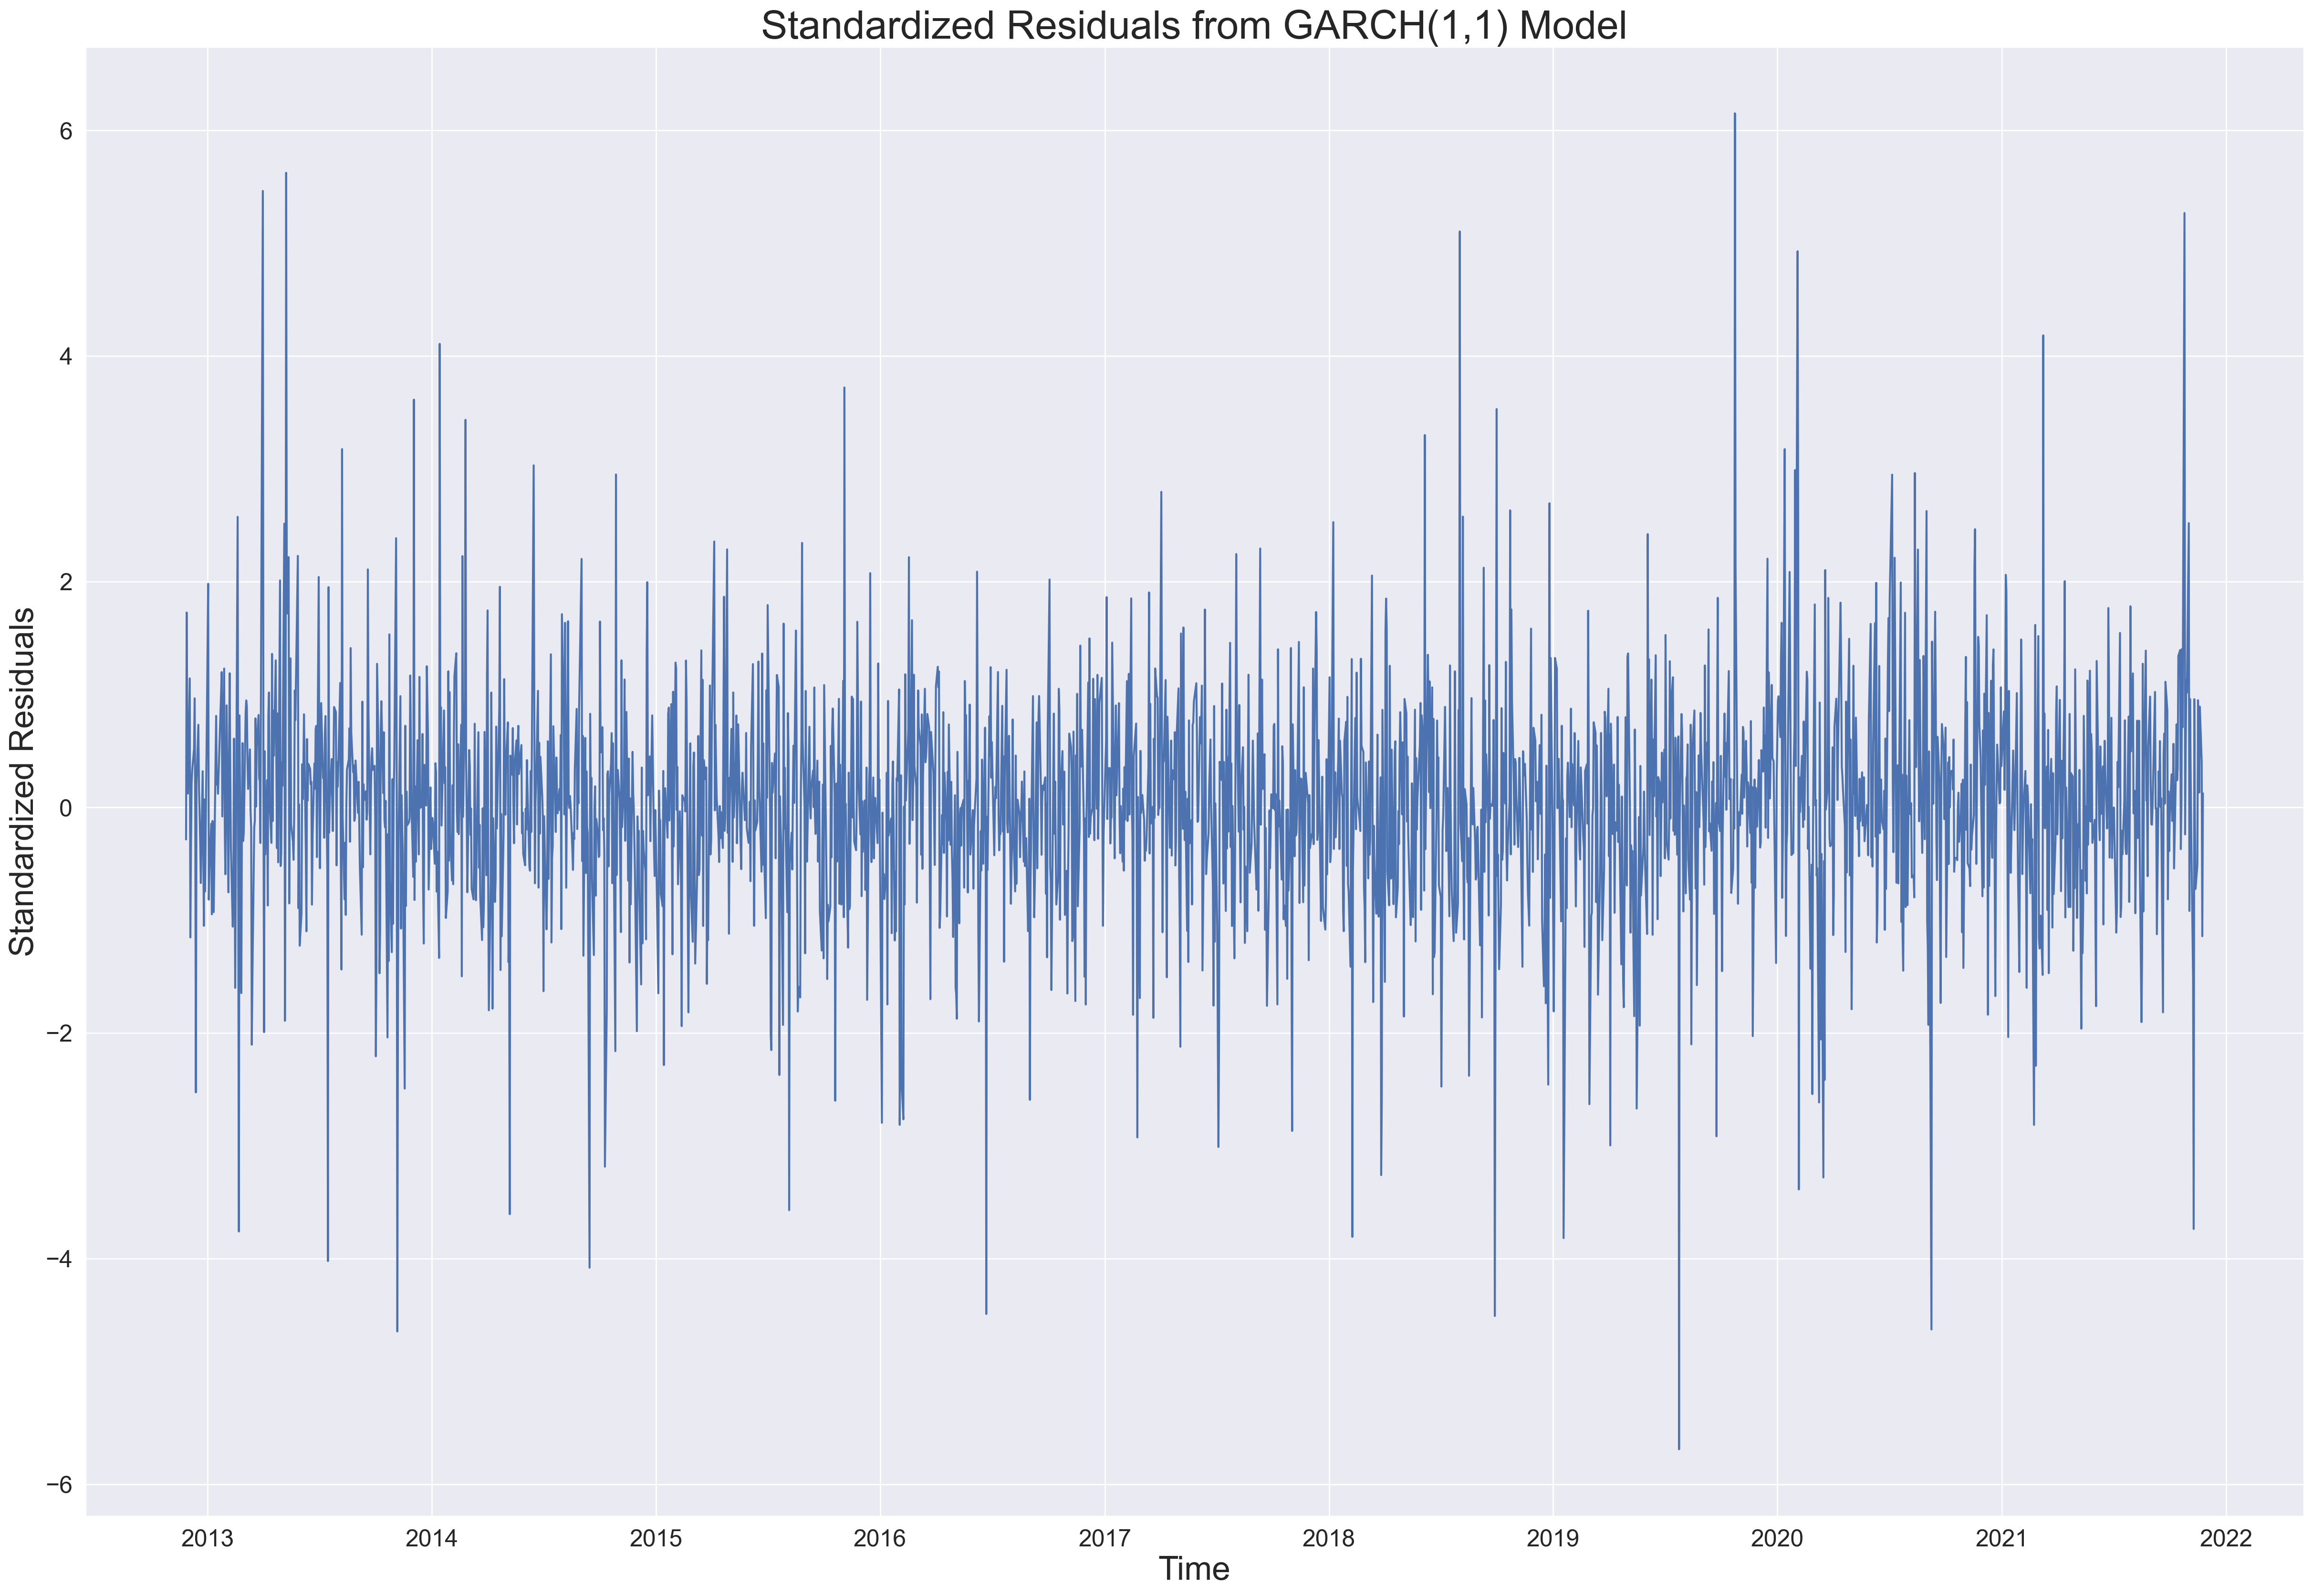

In [78]:
standardized_resid = res.std_resid

plt.figure(figsize=(30, 20))
sns.lineplot(x=train_df.Date, y=standardized_resid)
plt.title("Standardized Residuals from GARCH(1,1) Model", fontsize=30)
plt.ylabel("Standardized Residuals", fontsize=25)
plt.xlabel("Time", fontsize=25)
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

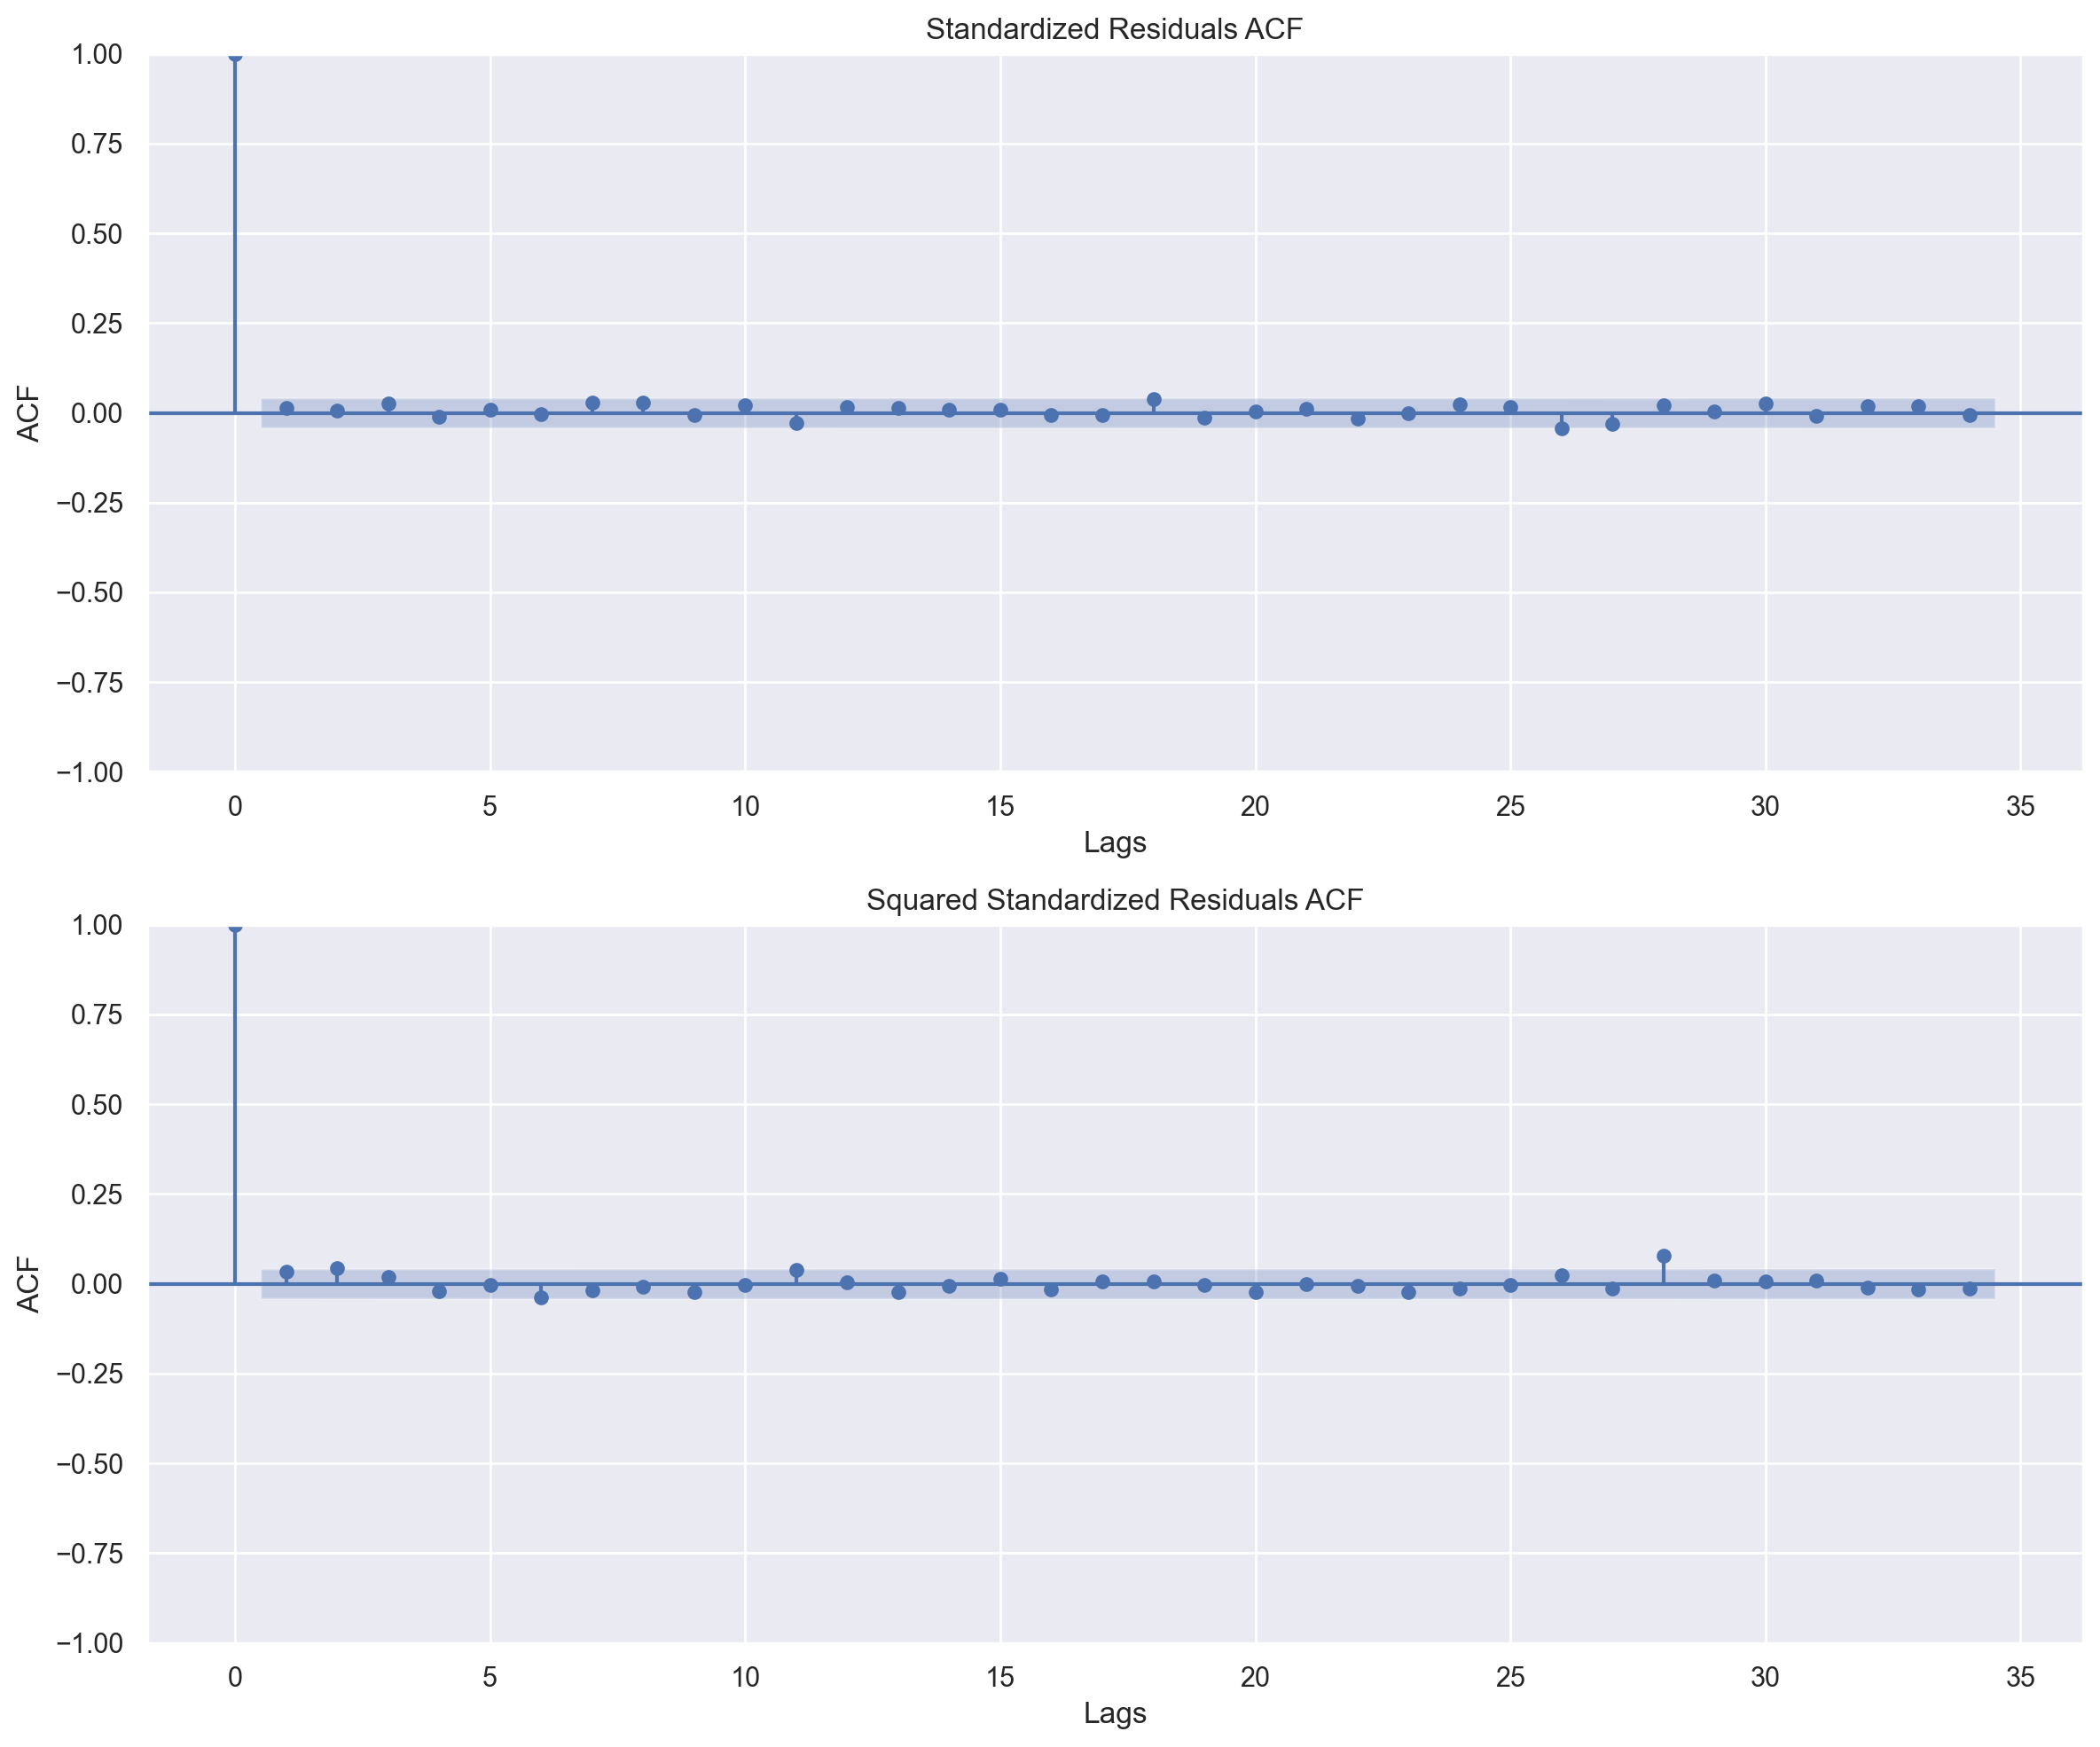

In [79]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

sm.graphics.tsa.plot_acf(standardized_resid, ax=ax[0])
sm.graphics.tsa.plot_acf(standardized_resid**2, ax=ax[1])
ax[0].set_title("Standardized Residuals ACF")
ax[0].set_xlabel("Lags")
ax[0].set_ylabel("ACF")
ax[1].set_title("Squared Standardized Residuals ACF")
ax[1].set_xlabel("Lags")
ax[1].set_ylabel("ACF")
plt.tight_layout()

plt.show()

residuals and squared residuals: non serially correlated -> consistent with independance assumption.

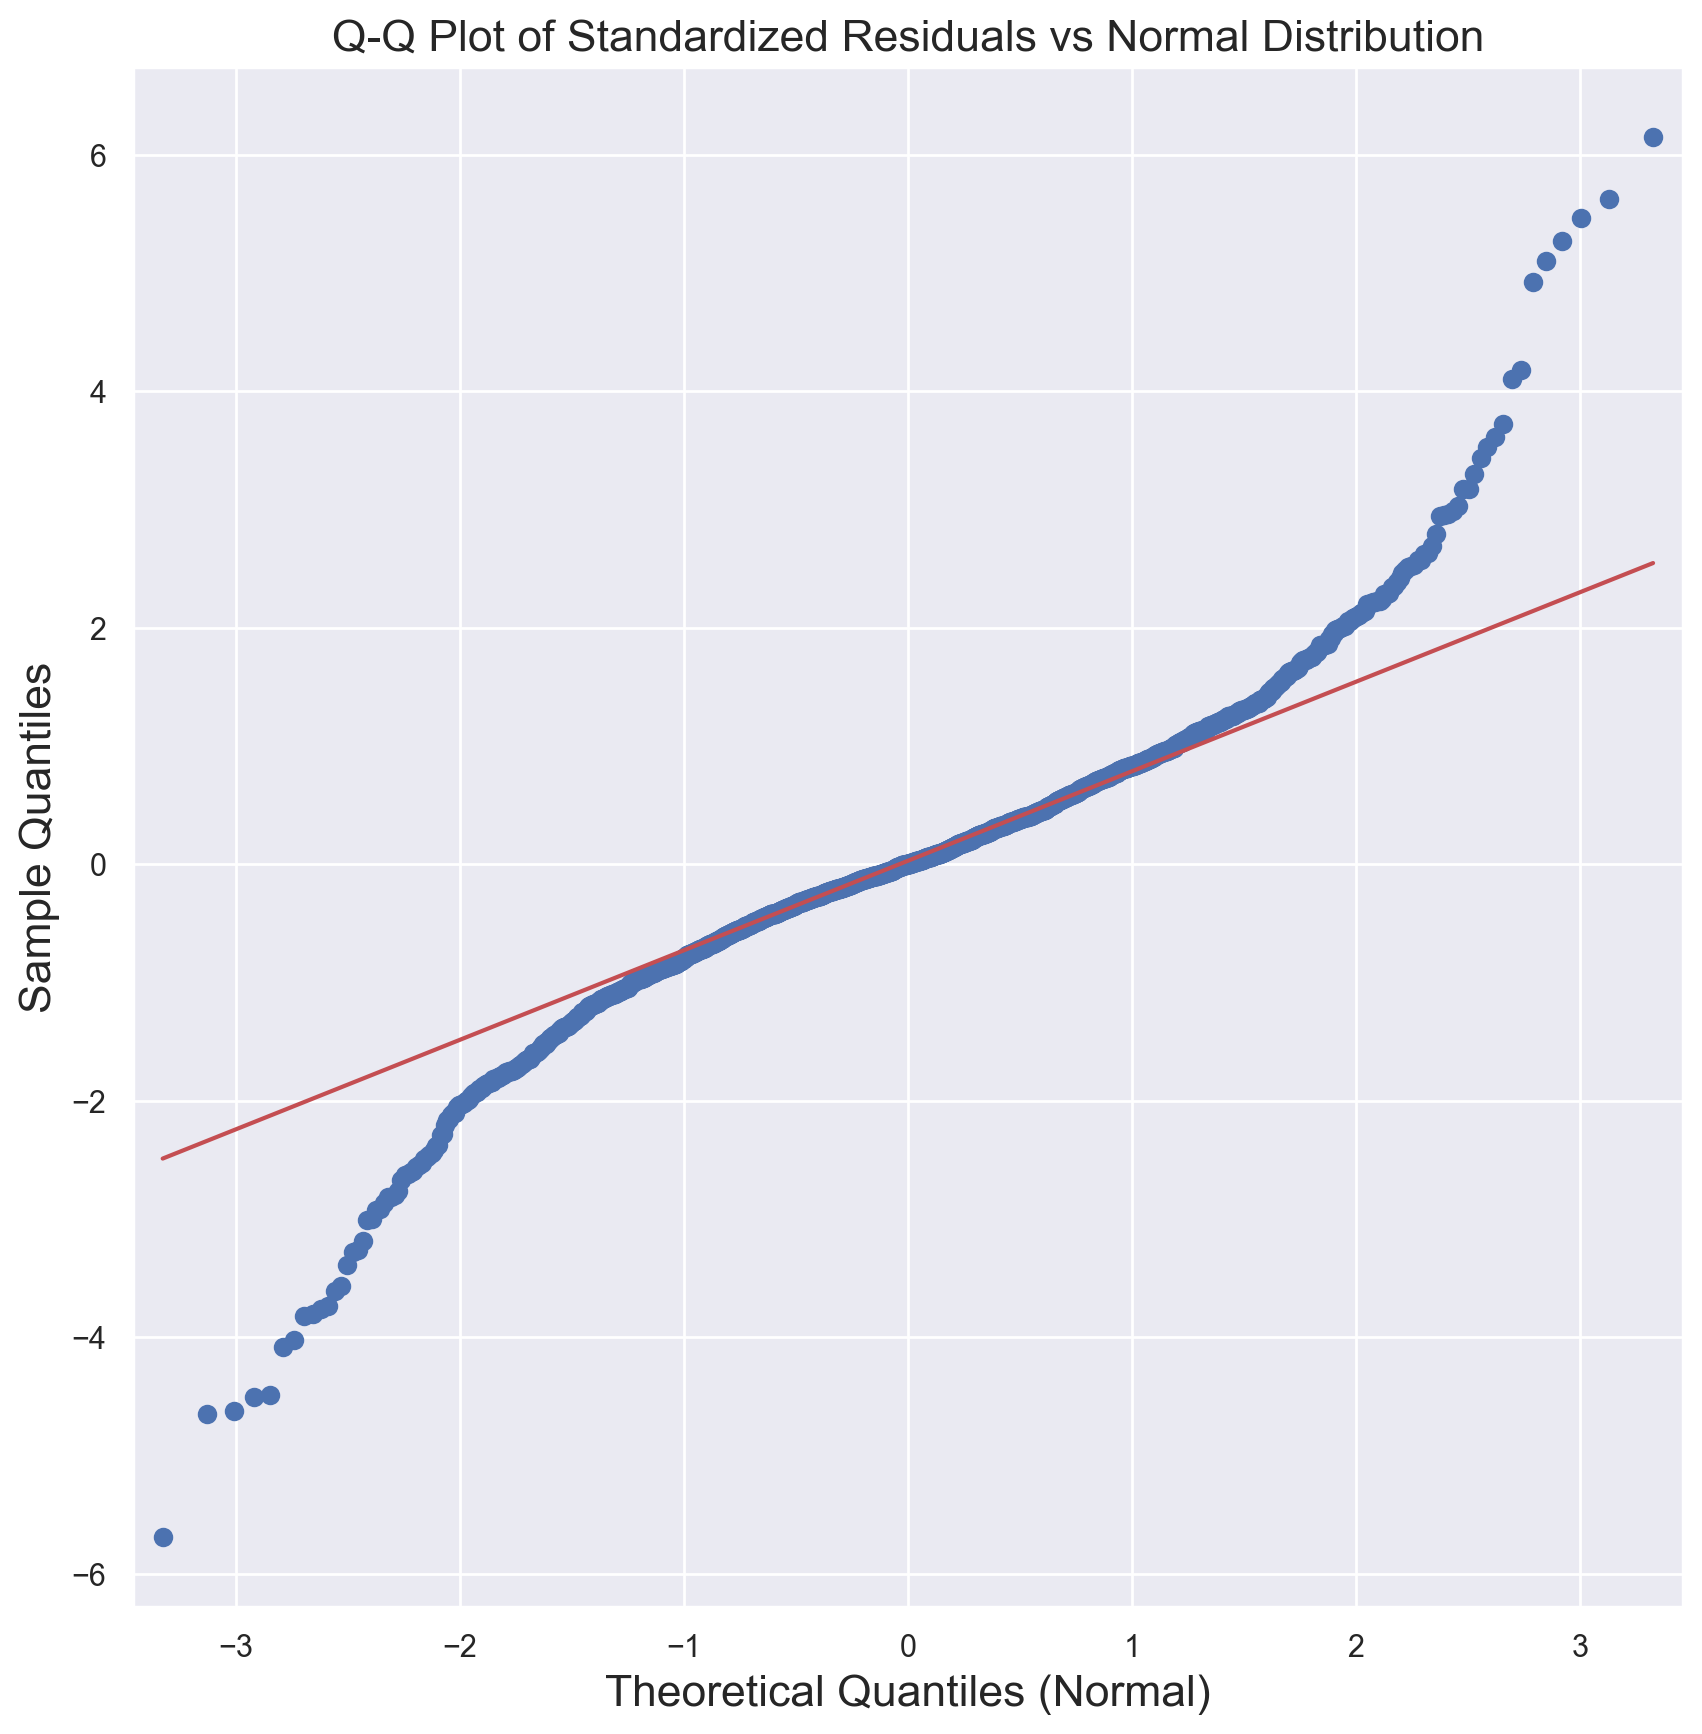

In [80]:
fig, ax = plt.subplots(figsize=(10, 10))
sm.qqplot(standardized_resid, dist=stats.norm, ax=ax, line='q')
plt.xlabel('Theoretical Quantiles (Normal)', fontsize=16)
plt.ylabel('Sample Quantiles', fontsize=16)
plt.title('Q-Q Plot of Standardized Residuals vs Normal Distribution', fontsize=16)
plt.show()

Tails seem heavier on the observed residuals distribution than on the theoretical normal distribution. 

In [81]:
df_estimate, loc_estim, scale_estim = stats.t.fit(standardized_resid)

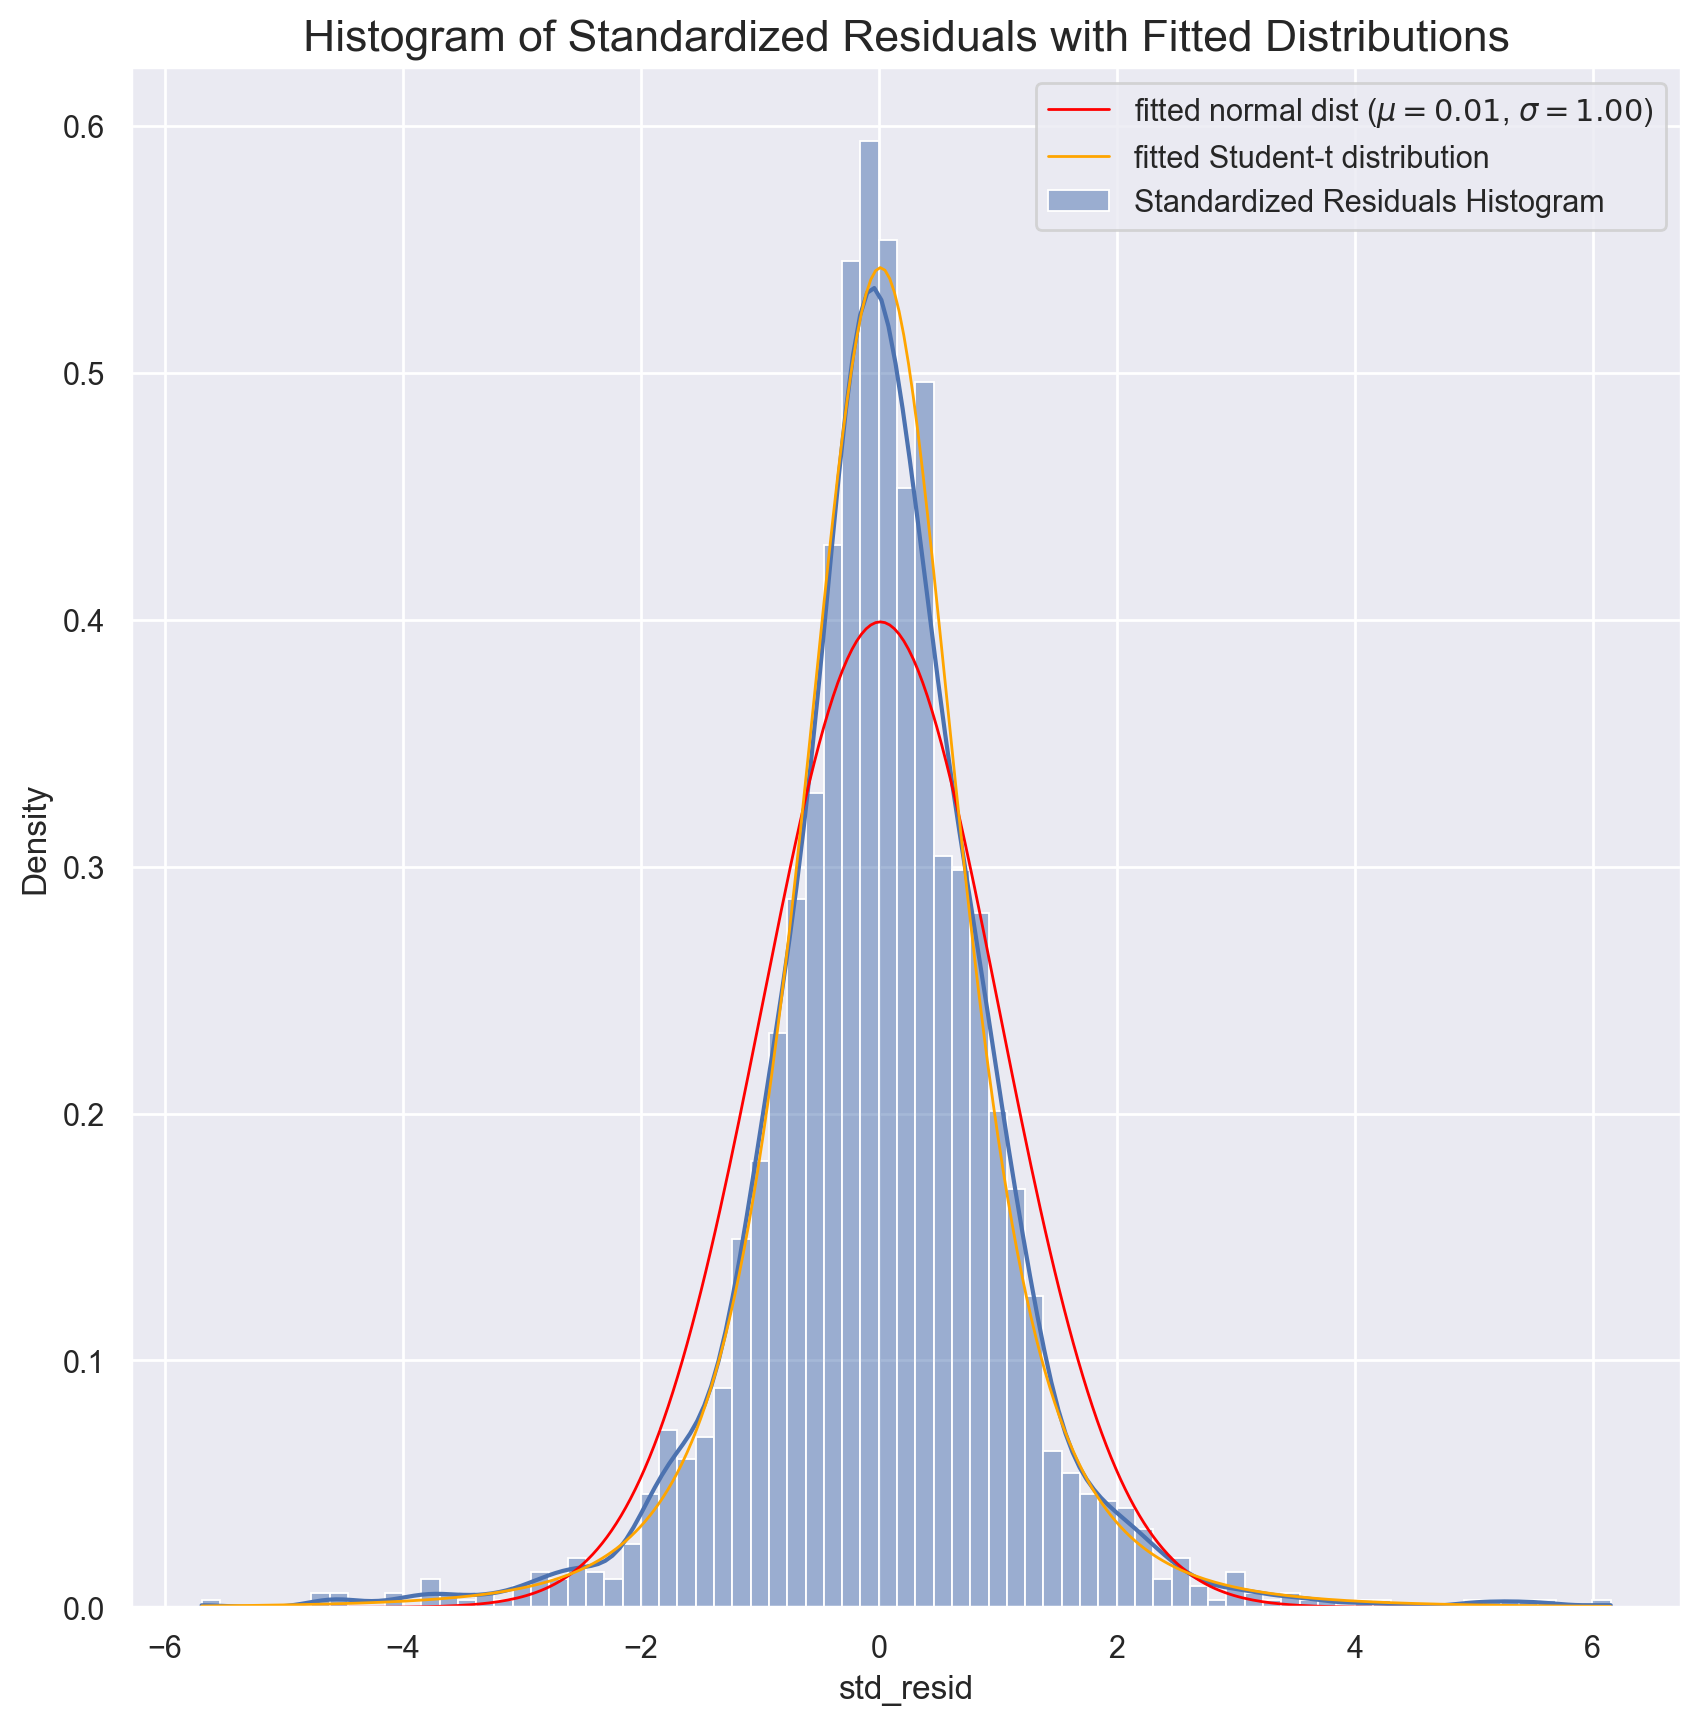

In [82]:
from scipy.stats import norm, t
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(standardized_resid, kde=True, ax=ax, stat='density', label='Standardized Residuals Histogram')
mean, std = np.mean(standardized_resid), np.std(standardized_resid)
xs = np.linspace(min(standardized_resid), max(standardized_resid), 300)
ax.plot(xs, norm.pdf(xs, mean, std), label=f"fitted normal dist ($\mu={mean:.2f}$, $\sigma={std:.2f}$)", linewidth=1, color='red')
ax.plot(xs, t.pdf(xs, df_estimate, loc_estim, scale_estim), label=f"fitted Student-t distribution", linewidth=1, color='orange')
ax.set_title("Histogram of Standardized Residuals with Fitted Distributions", fontsize=16)
ax.legend()

plt.show()

The student-t distribution seems to be a better fit. 

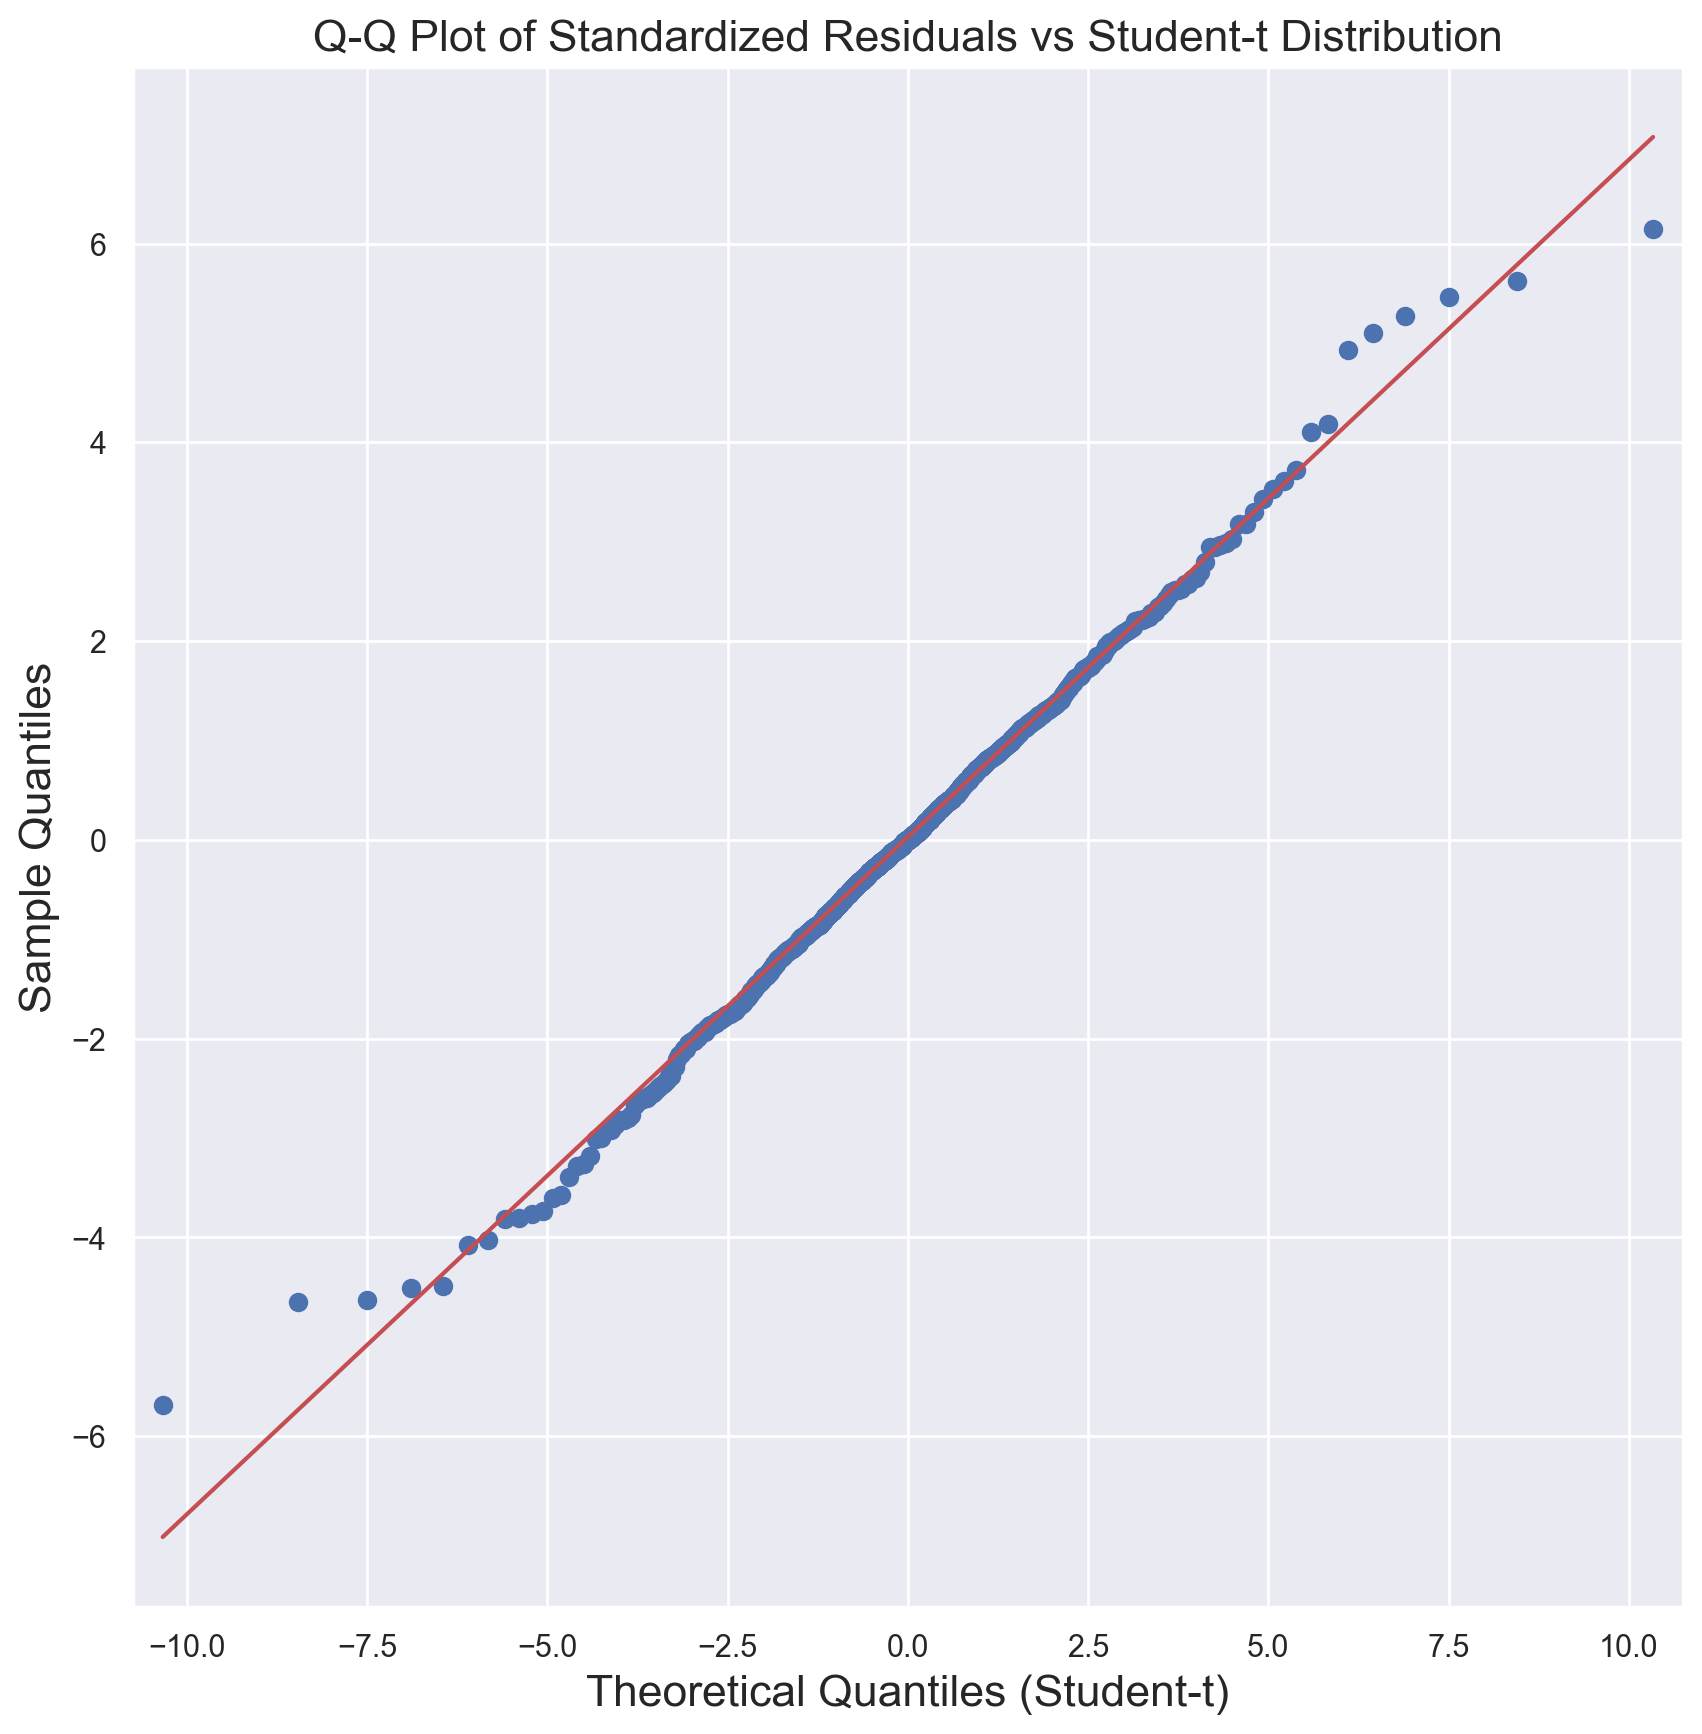

In [83]:
fig, ax = plt.subplots(figsize=(10, 10))
sm.qqplot(standardized_resid, dist=stats.t, distargs=(df_estimate,), ax=ax, line='q')
plt.xlabel('Theoretical Quantiles (Student-t)', fontsize=16)
plt.ylabel('Sample Quantiles', fontsize=16)
plt.title('Q-Q Plot of Standardized Residuals vs Student-t Distribution', fontsize=16)
plt.show()

The standard residuals seem to be drawn from a Student-t distribution. Thus, the assumption of the residuals being identically-distributed seems fair. 

In [84]:
train_df.loss.sum()

np.float64(515.2806204254168)

In [85]:
thresholds = res.std_resid.sort_values().to_list()
x = []
excess_means = []
for thresh in thresholds:
    excess_df = res.std_resid[res.std_resid>thresh]-thresh
    nb_excess = excess_df.count()
    excess_mean = excess_df.sum()/nb_excess if nb_excess>0 else None
    if len(excess_means)>0 and excess_mean!=excess_means[-1]:
        excess_means.append(excess_mean)
        x.append(thresh)
    elif len(excess_means)==0:
        excess_means.append(excess_mean)
        x.append(thresh)

C:\Users\ilias\AppData\Local\Temp\ipykernel_4192\995912475.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


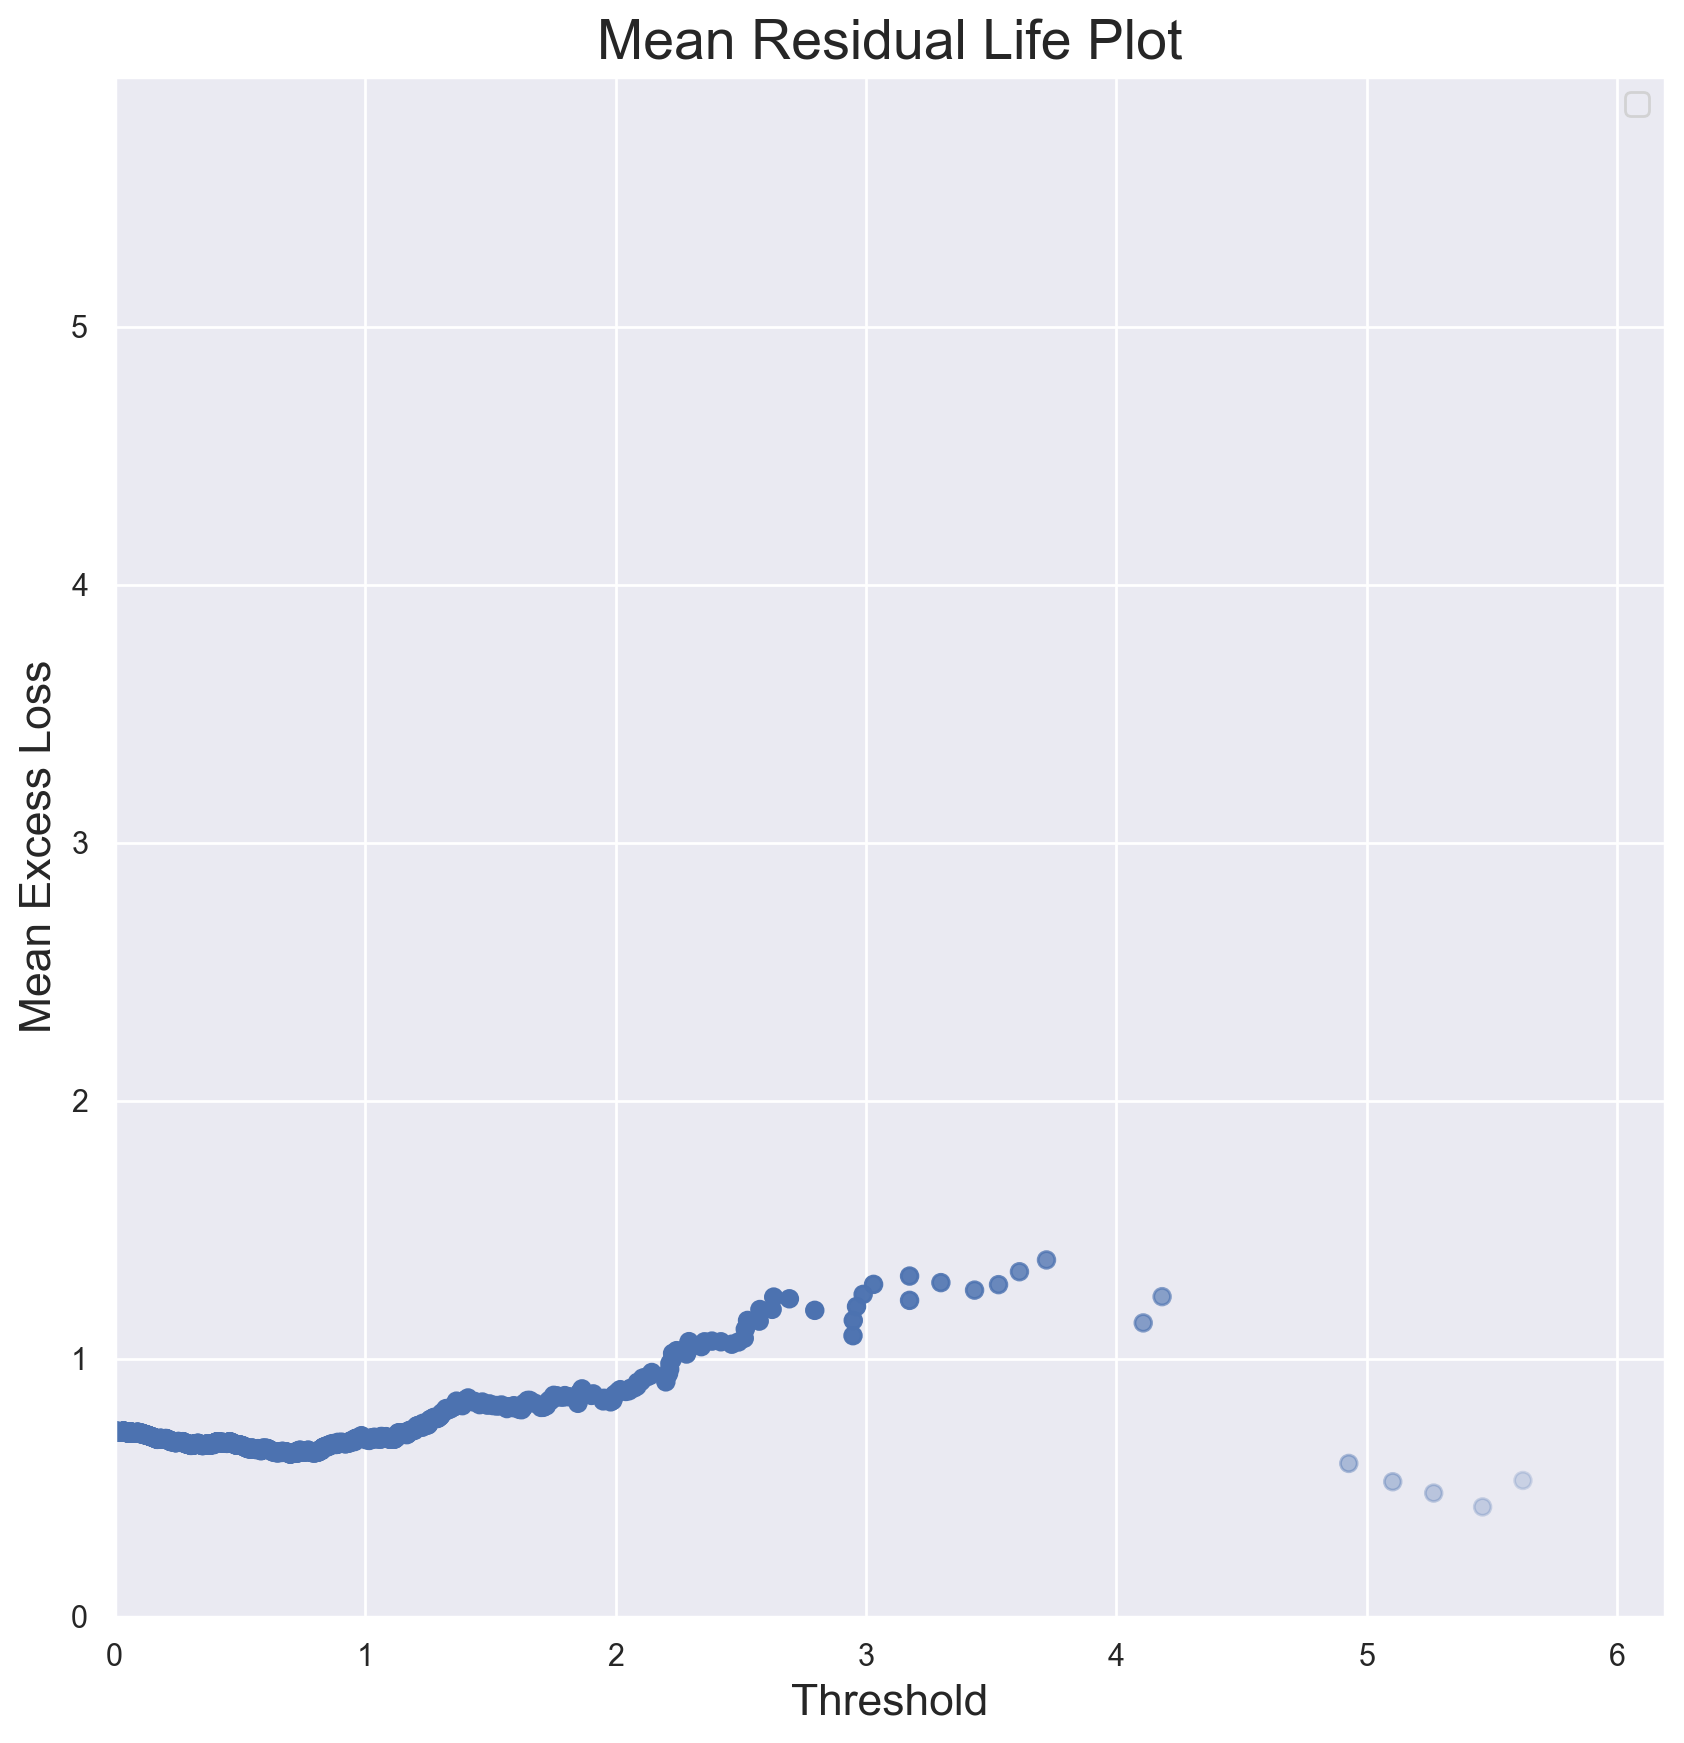

In [86]:
fig, ax = plt.subplots(figsize=(10, 10))

x = np.array(x)
threshold = 2.9
alphas = np.ones_like(x)
mask = x > threshold
alphas[mask] = 1 - (x[mask] - threshold) / (x.max() - threshold) * (1 - 0.05)

plt.scatter(x, excess_means, alpha=alphas)



plt.legend()
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Mean Excess Loss', fontsize=16)
plt.title('Mean Residual Life Plot', fontsize=20)
plt.ylim(0)
plt.xlim(0)
plt.show()

There seems to be two linear tendencies on the mean excess plot. We want to have a linear trend after a certain threshold u. This threshold is set at u=1, as we can see on the graph above the mean excess loss is fairly linear, except for some extremity points. 

In [87]:
u = 1
excess_df = res.std_resid[res.std_resid>u]-u


In [88]:
from scipy.stats import genpareto
params = genpareto.fit(excess_df)

In [89]:
GPD_shape, GPD_loc, GPD_scale  = params

In [90]:
params

(np.float64(0.19235233124315387),
 np.float64(0.003396542171041738),
 np.float64(0.5533943509053127))

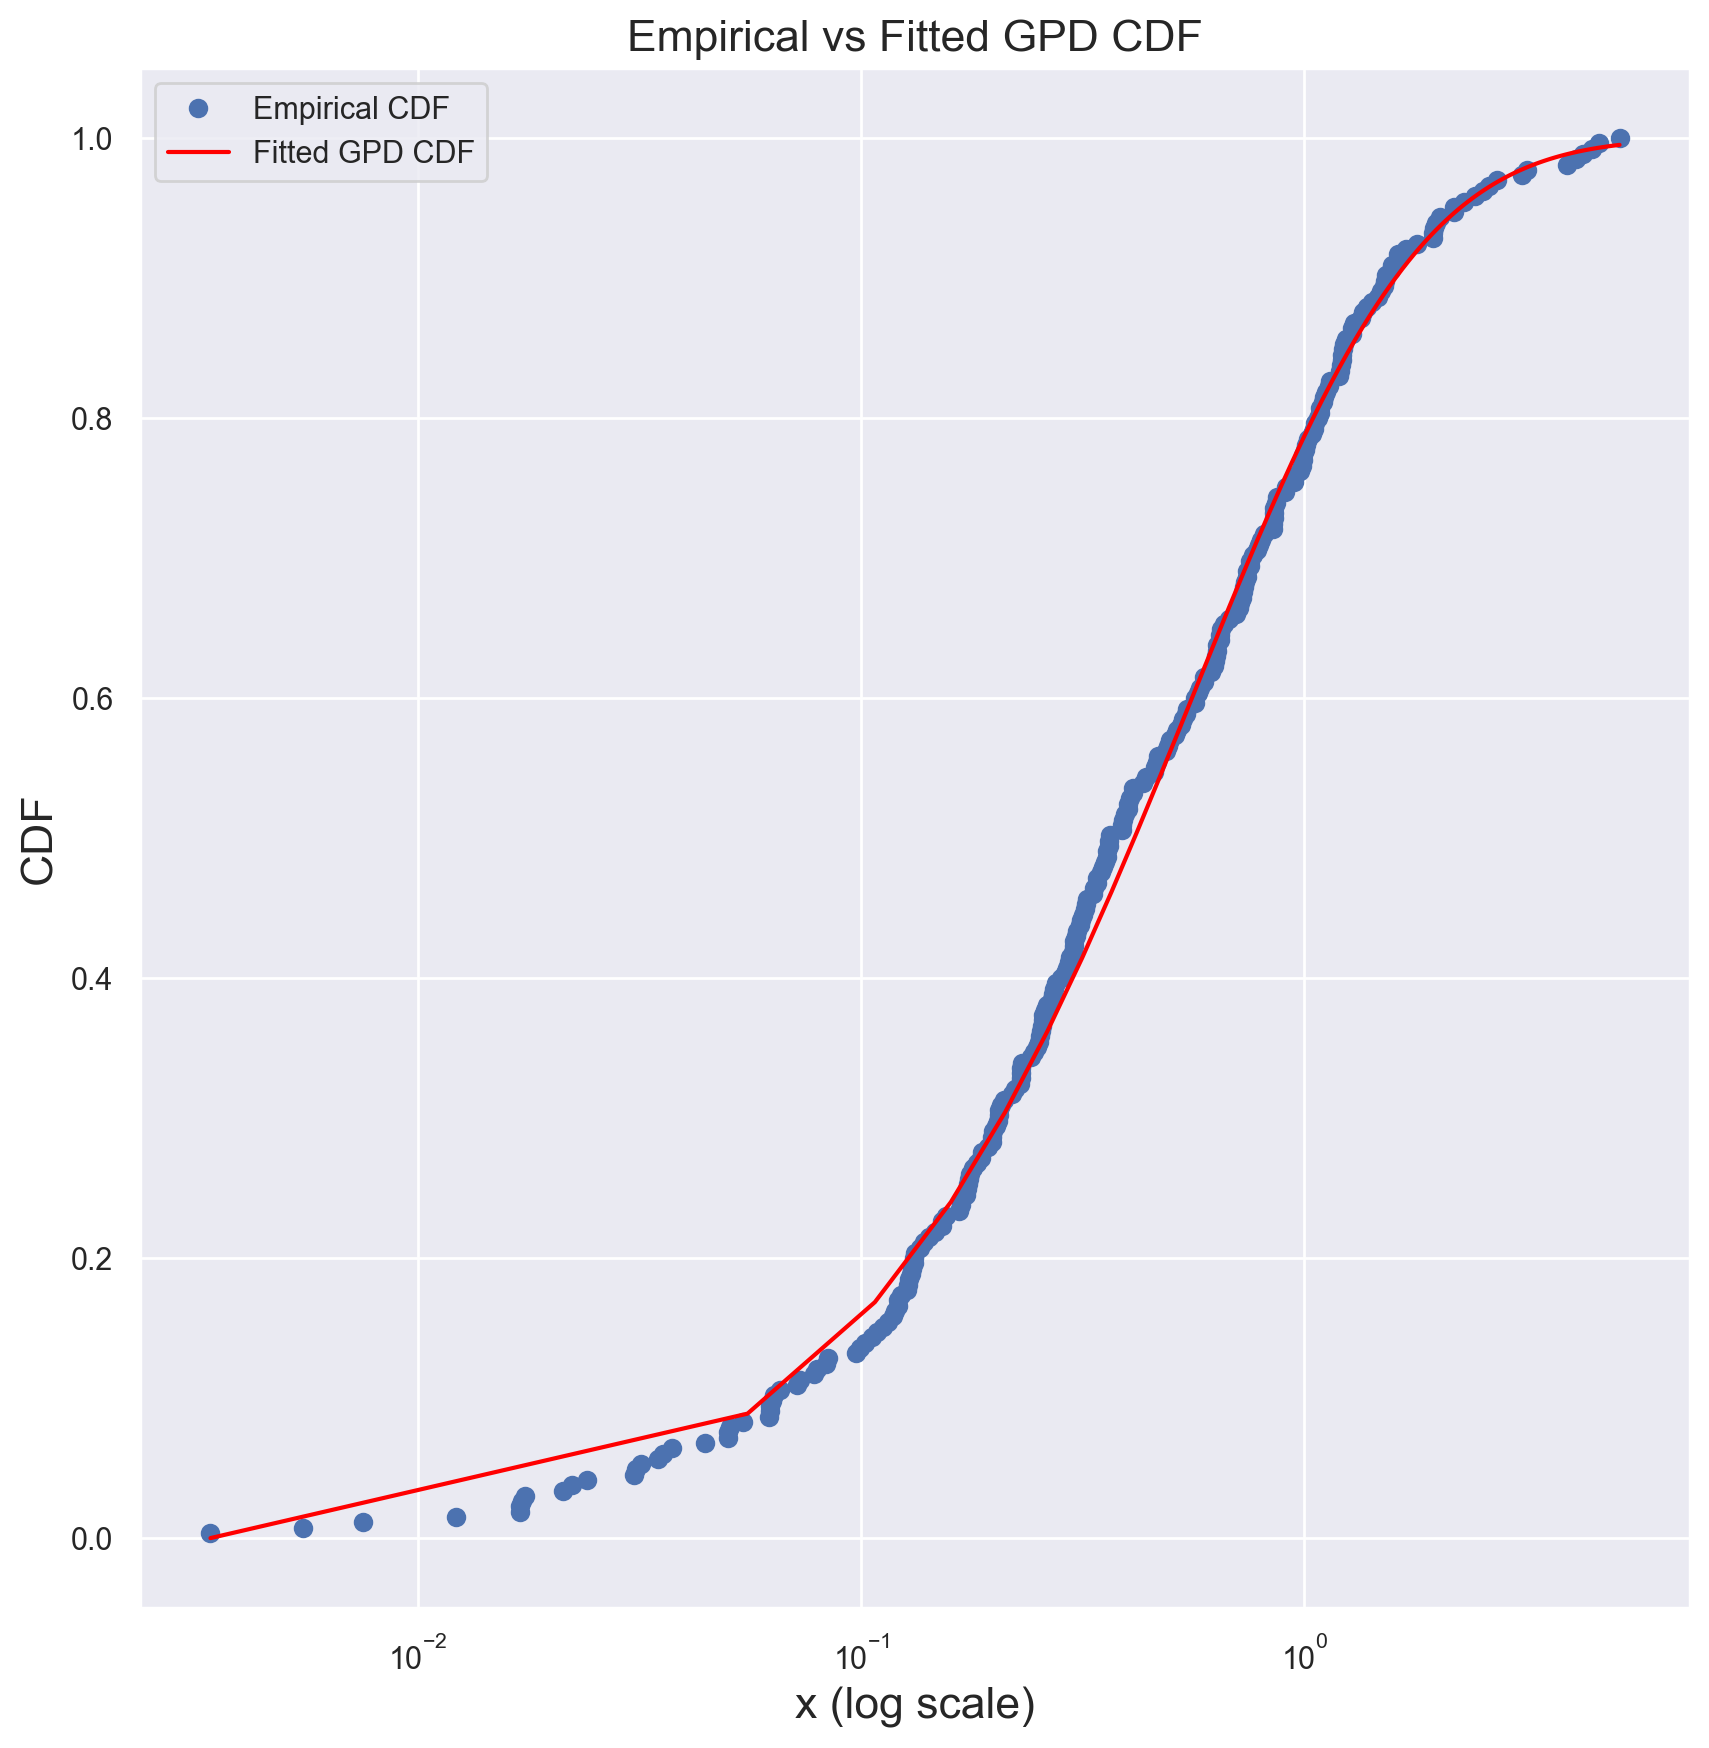

In [91]:
sorted = excess_df.sort_values().reset_index(drop=True)
cdf_values = []
for i in range(len(excess_df)):
        cdf_value = np.sum(sorted <= sorted[i]) / len(excess_df)
        cdf_values.append(cdf_value)


plt.figure(figsize=(10, 10))
plt.plot(np.sort(excess_df), cdf_values, marker='o', linestyle='', label='Empirical CDF')
x = np.linspace(min(excess_df), max(excess_df), 100)
plt.plot(x, genpareto.cdf(x, params[0], params[1], params[2]), label='Fitted GPD CDF', color='red')
plt.legend()
plt.gca().set_xscale('log', base=10)
plt.title("Empirical vs Fitted GPD CDF", fontsize=16)
plt.xlabel("x (log scale)", fontsize=16)
plt.ylabel("CDF", fontsize=16)
plt.show()

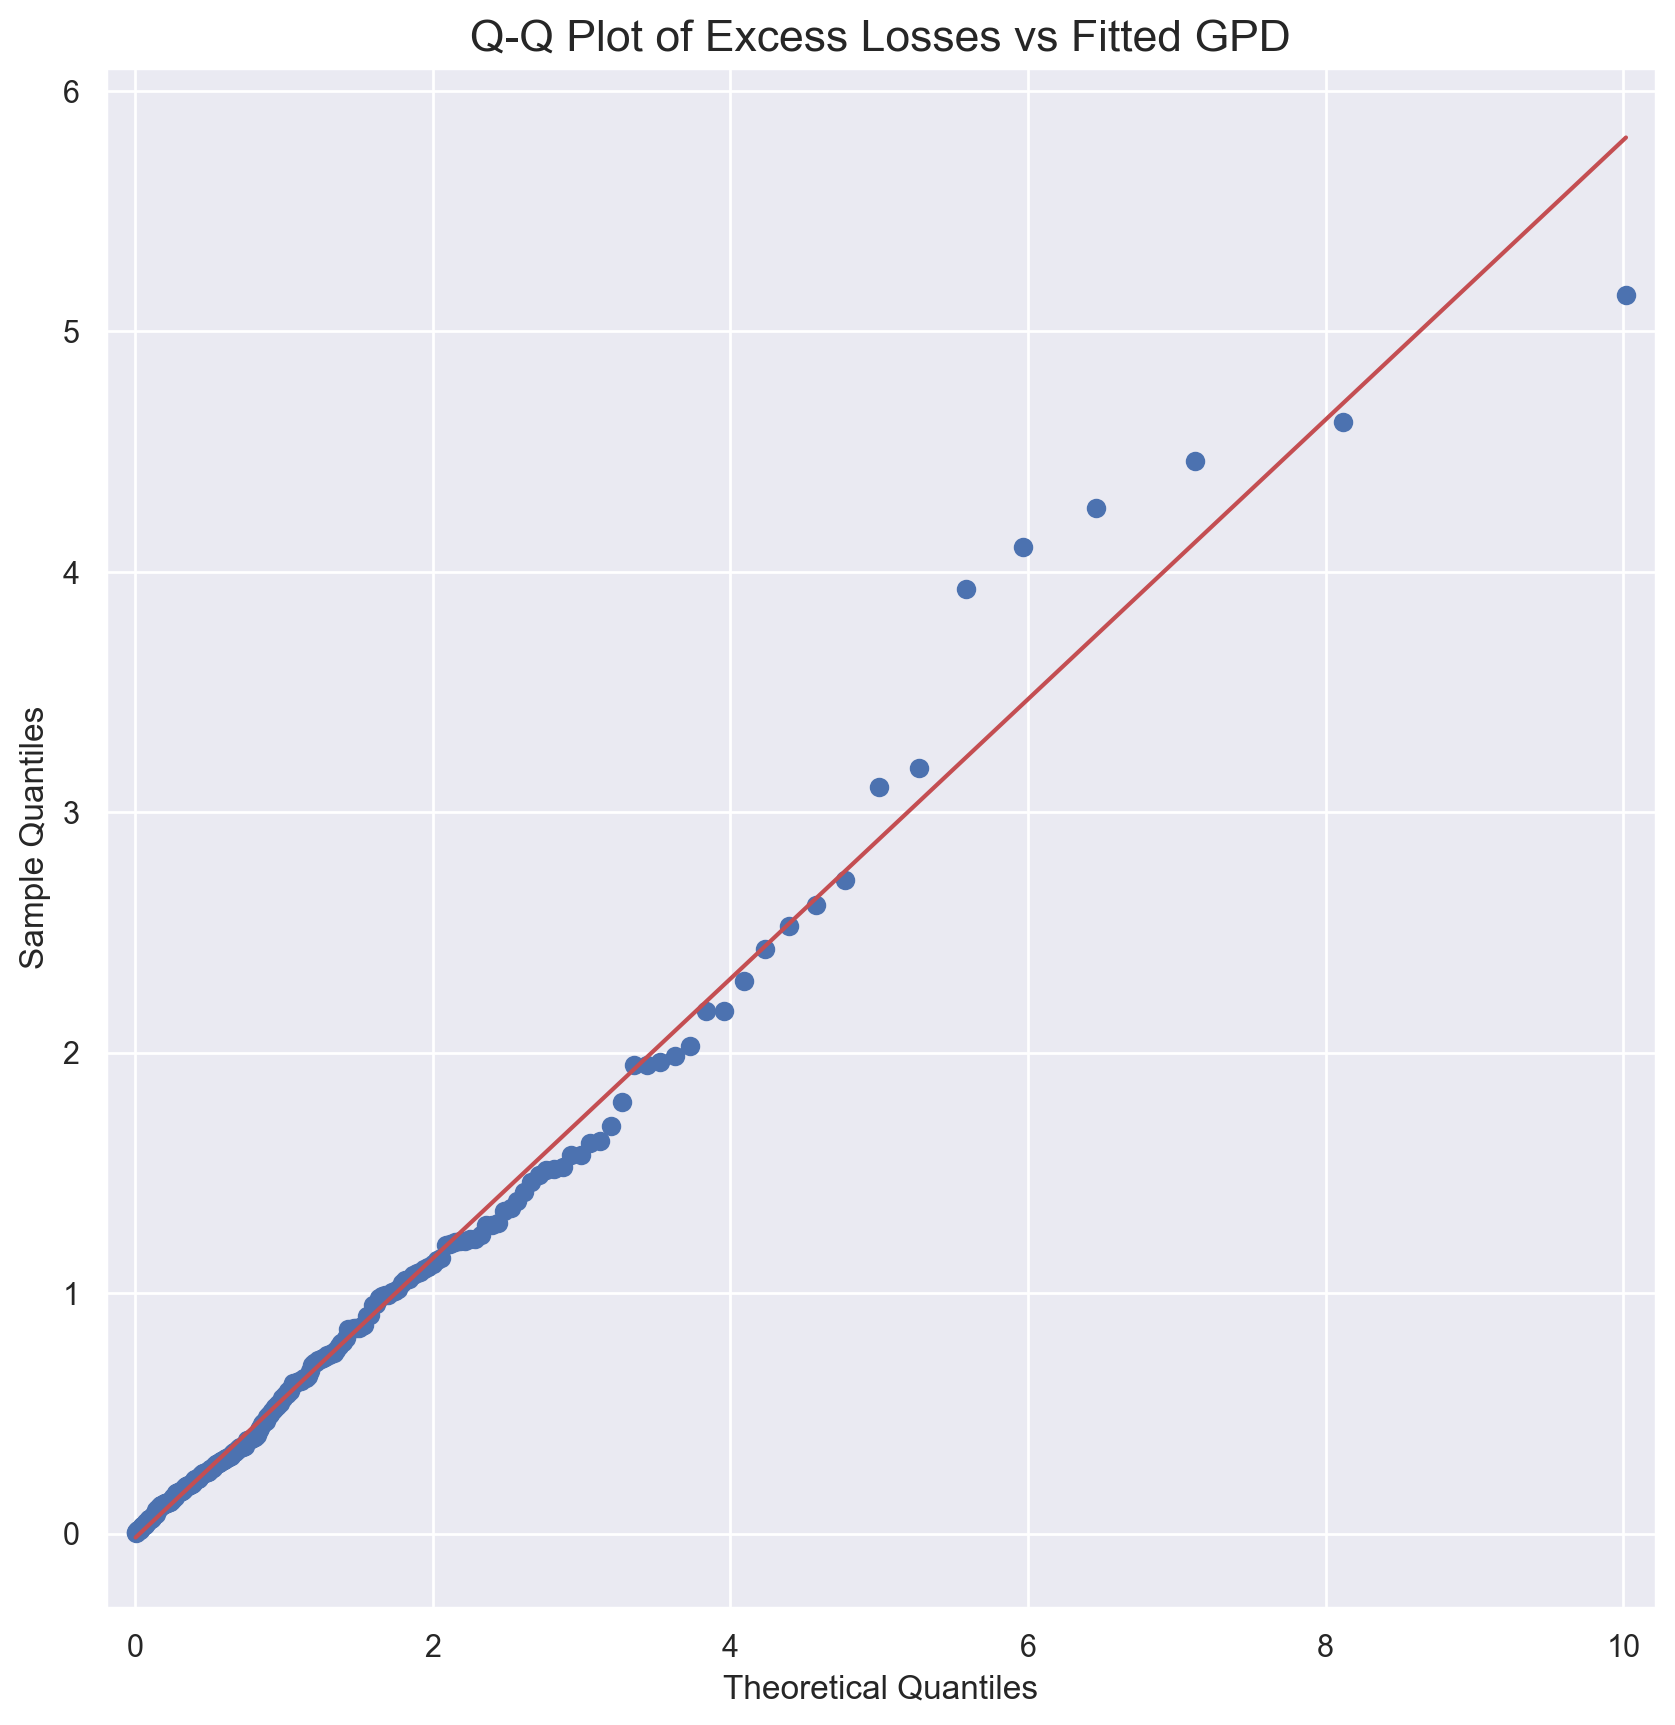

In [92]:
fig, ax = plt.subplots(figsize=(10, 10))
sm.qqplot(excess_df, dist=genpareto, distargs=(params[0],), ax=ax, line='r')
plt.title('Q-Q Plot of Excess Losses vs Fitted GPD', fontsize=16)
plt.show()

In [93]:
from scipy.stats import kstest
ks_statistic, p_value = kstest(excess_df, 'genpareto', args=params)
alpha = 0.05
if p_value < alpha:
    print(f"The p-value ({p_value:.4f}) is less than {alpha}, so we reject the null hypothesis.")
    print("The data does not appear to follow a Generalized Pareto Distribution with the estimated parameters.")
else:
    print(f"The p-value ({p_value:.4f}) is greater than {alpha}, so we fail to reject the null hypothesis.")
    print("The data appears to follow a Generalized Pareto Distribution with the estimated parameters.")

The p-value (0.7136) is greater than 0.05, so we fail to reject the null hypothesis.
The data appears to follow a Generalized Pareto Distribution with the estimated parameters.


## VaR with GARCH(1,1) and normal innovations

Fitting the model on train data

In [94]:
Garch_normal = arch_model(train_df.loss, p=1, q=1, vol='GARCH', mean='constant', dist='normal')
res = Garch_normal.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 109977.43472223838
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7646.948143837401
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5878.970834915617
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5902.87203617076
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5882.501525208385
Iteration:      6,   Func. Count:     38,   Neg. LLF: 5864.248120761451
Iteration:      7,   Func. Count:     44,   Neg. LLF: 5926.7993379015425
Iteration:      8,   Func. Count:     51,   Neg. LLF: 5896.344203611621
Iteration:      9,   Func. Count:     57,   Neg. LLF: 5854.909254442988
Iteration:     10,   Func. Count:     62,   Neg. LLF: 5854.909119616166
Iteration:     11,   Func. Count:     67,   Neg. LLF: 5854.909118900442
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5854.909118900442
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 1

In [95]:
res

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   loss   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5854.91
Distribution:                  Normal   AIC:                           11717.8
Method:            Maximum Likelihood   BIC:                           11740.7
                                        No. Observations:                 2266
Date:                Tue, Dec 02 2025   Df Residuals:                     2265
Time:                        19:25:33   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1506  6.416e-02      2.347  1.891e-02 [2.485e-0

In [96]:
preds = res.forecast(horizon=len(test_df))
mus = preds.mean.squeeze()
sigmas = np.sqrt(preds._residual_variance.squeeze())

In [97]:
stats.norm.ppf(0.95)
stats.norm.ppf(0.99)

np.float64(2.3263478740408408)

In [98]:
mus.index = test_df.Date
sigmas.index = test_df.Date

compute VaR

In [99]:
test_df['mus'], test_df['sigmas'] = mus.values, sigmas.values
test_df['VaR95'] = test_df['mus'] + test_df['sigmas']*stats.norm.ppf(0.95)
test_df['VaR99'] = test_df['mus'] + test_df['sigmas']*stats.norm.ppf(0.99)

### Compute ES
formula part 2 p.58, phi functions defined p.52 as pdf, cdf

In [100]:
test_df['ES95'] = test_df['mus'] + (test_df['sigmas']*stats.norm.pdf(stats.norm.ppf(0.05)))/0.05
test_df['ES99'] = test_df['mus'] + (test_df['sigmas']*stats.norm.pdf(stats.norm.ppf(0.01)))/0.01

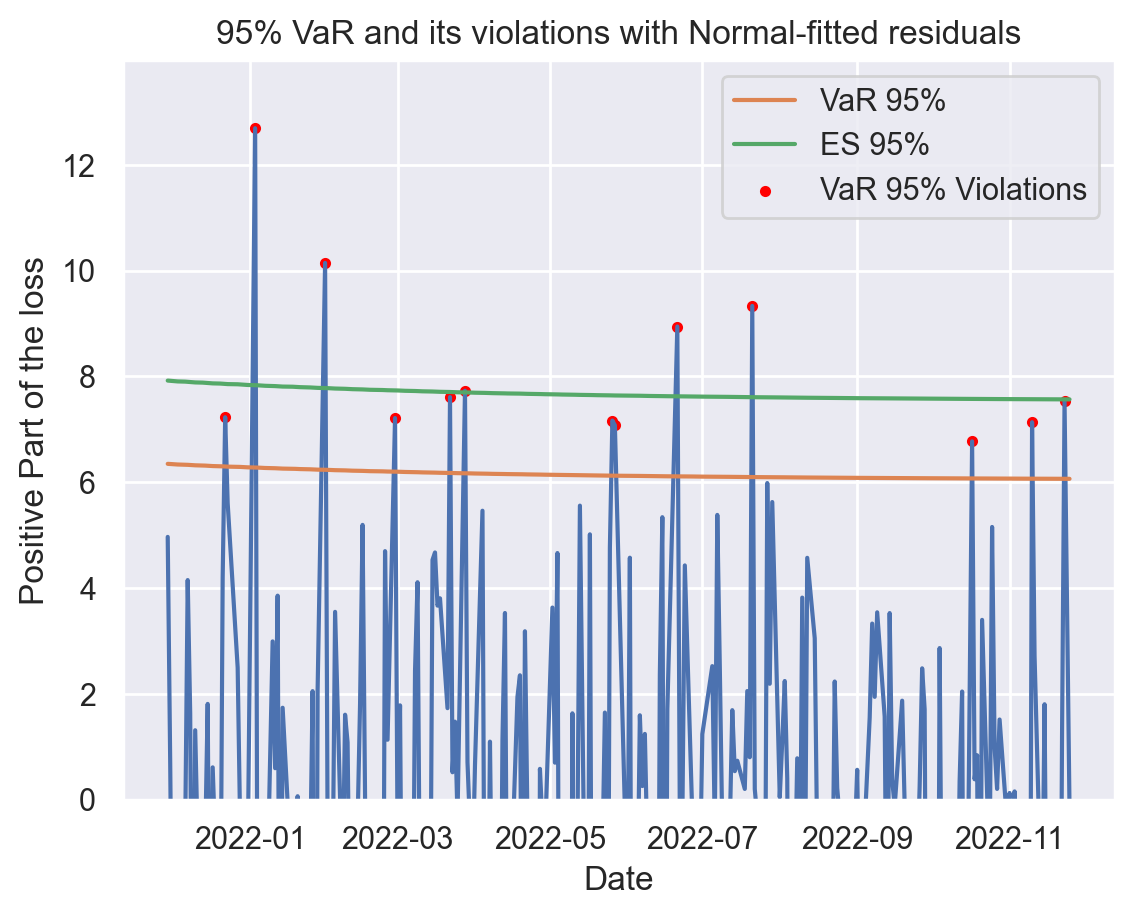

In [101]:
plt.plot(test_df.Date, test_df['loss'])
plt.plot(test_df.Date, test_df['VaR95'], label='VaR 95%')
plt.plot(test_df.Date, test_df['ES95'], label='ES 95%')

plt.ylim(0)
plt.ylabel('Positive Part of the loss')
plt.xlabel('Date')
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

violations = test_df[test_df['loss'] > test_df['VaR95']]
plt.scatter(violations.Date, violations.loss, color='red', marker='.', label='VaR 95% Violations')
plt.legend()
plt.title('95% VaR and its violations with Normal-fitted residuals')
plt.show()


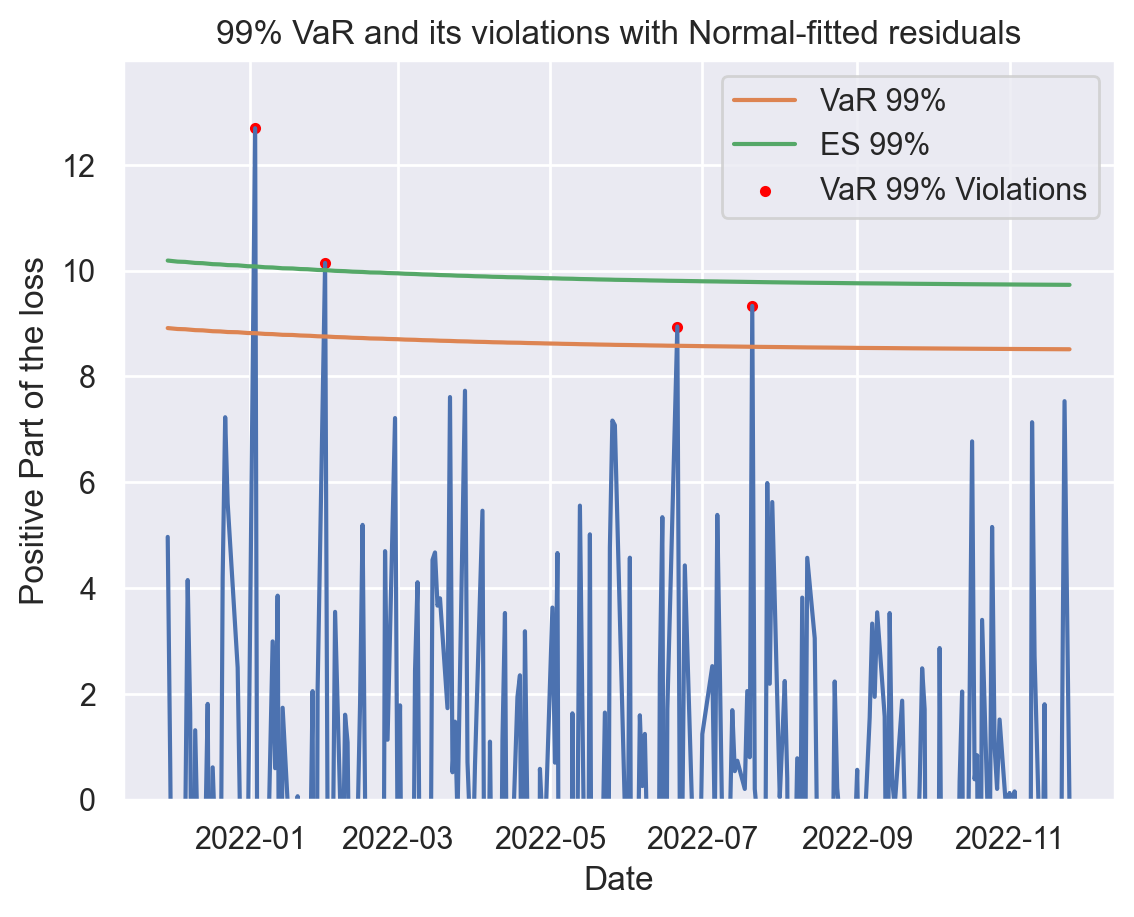

In [102]:
plt.plot(test_df.Date, test_df['loss'])
plt.plot(test_df.Date, test_df['VaR99'], label='VaR 99%')
plt.plot(test_df.Date, test_df['ES99'], label='ES 99%')

plt.ylim(0)
plt.ylabel('Positive Part of the loss')
plt.xlabel('Date')
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

violations = test_df[test_df['loss'] > test_df['VaR99']]
plt.scatter(violations.Date, violations.loss, color='red', marker='.', label='VaR 99% Violations')
plt.legend()
plt.title('99% VaR and its violations with Normal-fitted residuals')
plt.show()


## GARCH(1,1) with standardized t-student innovations

In [103]:
Garch_t = arch_model(train_df.loss, p=1, q=1, vol='GARCH', mean='constant', dist='t')
res = Garch_t.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 53371.352146943726
Iteration:      2,   Func. Count:     15,   Neg. LLF: 58997.98097858561
Iteration:      3,   Func. Count:     24,   Neg. LLF: 9431.712458270858
Iteration:      4,   Func. Count:     33,   Neg. LLF: 7222.195873026622
Iteration:      5,   Func. Count:     40,   Neg. LLF: 6376.343660116498
Iteration:      6,   Func. Count:     47,   Neg. LLF: 7406.9078803776565
Iteration:      7,   Func. Count:     54,   Neg. LLF: 5681.16565525633
Iteration:      8,   Func. Count:     61,   Neg. LLF: 5678.13517294055
Iteration:      9,   Func. Count:     68,   Neg. LLF: 7216.493821495537
Iteration:     10,   Func. Count:     75,   Neg. LLF: 5673.941018777678
Iteration:     11,   Func. Count:     81,   Neg. LLF: 5673.900408927042
Iteration:     12,   Func. Count:     87,   Neg. LLF: 5673.898056311651
Iteration:     13,   Func. Count:     93,   Neg. LLF: 5673.897929073833
Iteration:     14,   Func. Count:     99,   Neg. LLF: 5673.89790

In [104]:
res

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         loss   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -5673.90
Distribution:      Standardized Student's t   AIC:                           11357.8
Method:                  Maximum Likelihood   BIC:                           11386.4
                                              No. Observations:                 2266
Date:                      Tue, Dec 02 2025   Df Residuals:                     2265
Time:                              19:25:33   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [105]:
df = res.params['nu']

In [106]:
preds = res.forecast(horizon=len(test_df))
must = preds.mean.squeeze()
sigmast = np.sqrt(preds._residual_variance.squeeze())

In [107]:
scale_std = np.sqrt((df - 2.0) / df)
q95 = stats.t.ppf(0.95, df=df, scale=1, loc=0)*scale_std
q99 = stats.t.ppf(0.99, df=df, scale=1, loc=0)*scale_std


### computing VaR

In [108]:
test_df['must'], test_df['sigmast'] = must.values, sigmast.values
test_df['VaR95t'] = test_df['must'] + test_df['sigmast']*q95
test_df['VaR99t'] = test_df['must'] + test_df['sigmast']*q99

### computing ES
formula part 2 p.58, phi functions defined p.52 as pdf, cdf adapted to the t-student distrib

In [109]:
test_df['ES95t'] = test_df['must'] + (test_df['sigmast']*stats.t.pdf(q95, df, loc=0, scale=1))/0.05
test_df['ES99t'] = test_df['must'] + (test_df['sigmast']*stats.t.pdf(q99, df, loc=0, scale=1))/0.01

In [110]:
test_df.head()

Date        TSLA  log_returns      loss       mus    sigmas  \
2268 2021-11-29  378.996674    -4.964716  4.964716  0.150609  3.766584   
2269 2021-11-30  381.586670    -0.681058  0.681058  0.150609  3.764631   
2270 2021-12-01  365.000000     4.444065 -4.444065  0.150609  3.762699   
2271 2021-12-02  361.533325     0.954313 -0.954313  0.150609  3.760787   
2272 2021-12-03  338.323334     6.635217 -6.635217  0.150609  3.758895   

         VaR95     VaR99      ES95       ES99      must   sigmast    VaR95t  \
2268  6.346088  8.912993  7.919990  10.189362  0.185897  3.878945  5.861372   
2269  6.342877  8.908452  7.915963  10.184159  0.185897  3.882575  5.866684   
2270  6.339699  8.903957  7.911977  10.179009  0.185897  3.886175  5.871951   
2271  6.336554  8.899508  7.908033  10.173912  0.185897  3.889743  5.877172   
2272  6.333441  8.895106  7.904129  10.168869  0.185897  3.893281  5.882348   

         VaR99t      ES95t      ES99t  
2268  10.498529  10.055982  12.108343  
2269  10.508182  10.065220  12.119502  
2270  10.517751  10.074379  12.130565  
2271  10.527238  10.083459  12.141534  
2272  10.536644  10.092462  12.152408

### plots

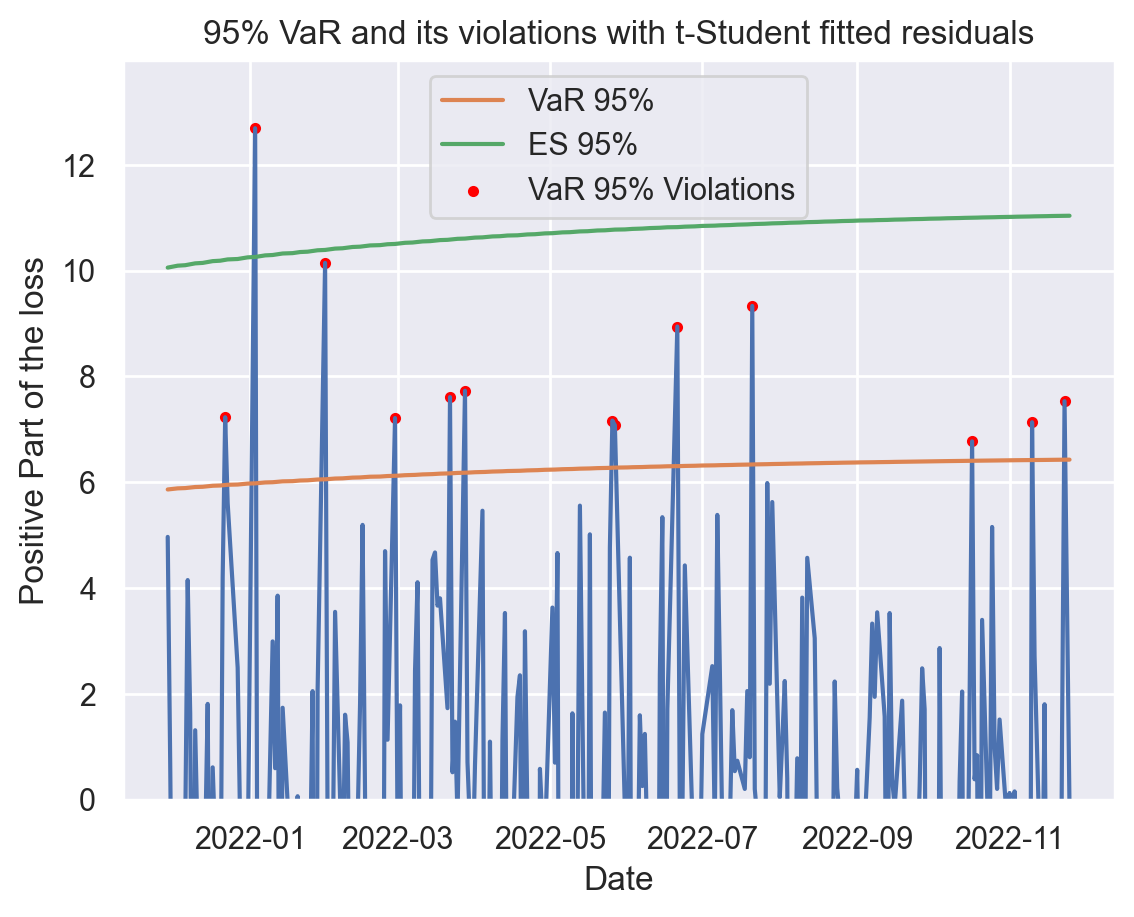

In [111]:
plt.plot(test_df.Date, test_df['loss'])
plt.plot(test_df.Date, test_df['VaR95t'], label='VaR 95%')
plt.plot(test_df.Date, test_df['ES95t'], label='ES 95%')

plt.ylim(0)
plt.ylabel('Positive Part of the loss')
plt.xlabel('Date')
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

violations = test_df[test_df['loss'] > test_df['VaR95t']]
plt.scatter(violations.Date, violations.loss, color='red', marker='.', label='VaR 95% Violations')
plt.legend()
plt.title('95% VaR and its violations with t-Student fitted residuals')
plt.show()


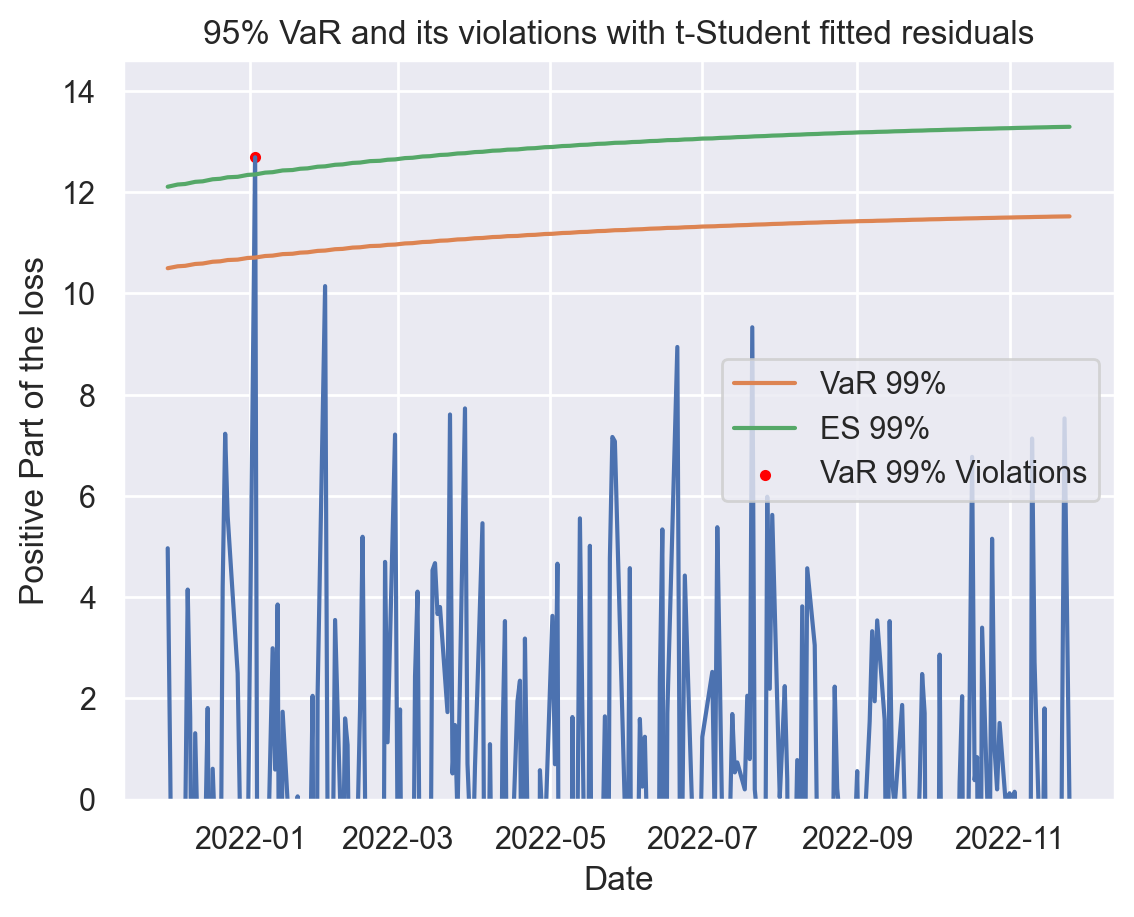

In [112]:
plt.plot(test_df.Date, test_df['loss'])
plt.plot(test_df.Date, test_df['VaR99t'], label='VaR 99%')
plt.plot(test_df.Date, test_df['ES99t'], label='ES 99%')

plt.ylim(0)
plt.ylabel('Positive Part of the loss')
plt.xlabel('Date')
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

violations = test_df[test_df['loss'] > test_df['VaR99t']]
plt.scatter(violations.Date, violations.loss, color='red', marker='.', label='VaR 99% Violations')
plt.legend()
plt.title('95% VaR and its violations with t-Student fitted residuals')
plt.show()


## GPD model of excess values

In [113]:
Garch_normal = arch_model(train_df.loss, p=1, q=1, vol='GARCH', mean='constant', dist='normal')
res = Garch_normal.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 109977.43472223838
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7646.948143837401
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5878.970834915617
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5902.87203617076
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5882.501525208385
Iteration:      6,   Func. Count:     38,   Neg. LLF: 5864.248120761451
Iteration:      7,   Func. Count:     44,   Neg. LLF: 5926.7993379015425
Iteration:      8,   Func. Count:     51,   Neg. LLF: 5896.344203611621
Iteration:      9,   Func. Count:     57,   Neg. LLF: 5854.909254442988
Iteration:     10,   Func. Count:     62,   Neg. LLF: 5854.909119616166
Iteration:     11,   Func. Count:     67,   Neg. LLF: 5854.909118900442
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5854.909118900442
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 1

In [114]:
preds = res.forecast(horizon=len(test_df))
mus = preds.mean.squeeze()
sigmas = np.sqrt(preds._residual_variance.squeeze())

In [115]:
from statsmodels.distributions.empirical_distribution import ECDF

zeta, beta = GPD_shape, GPD_scale
ecdf = ECDF(res.std_resid)
F_u = ecdf(u)
print(F_u)

0.883053839364519


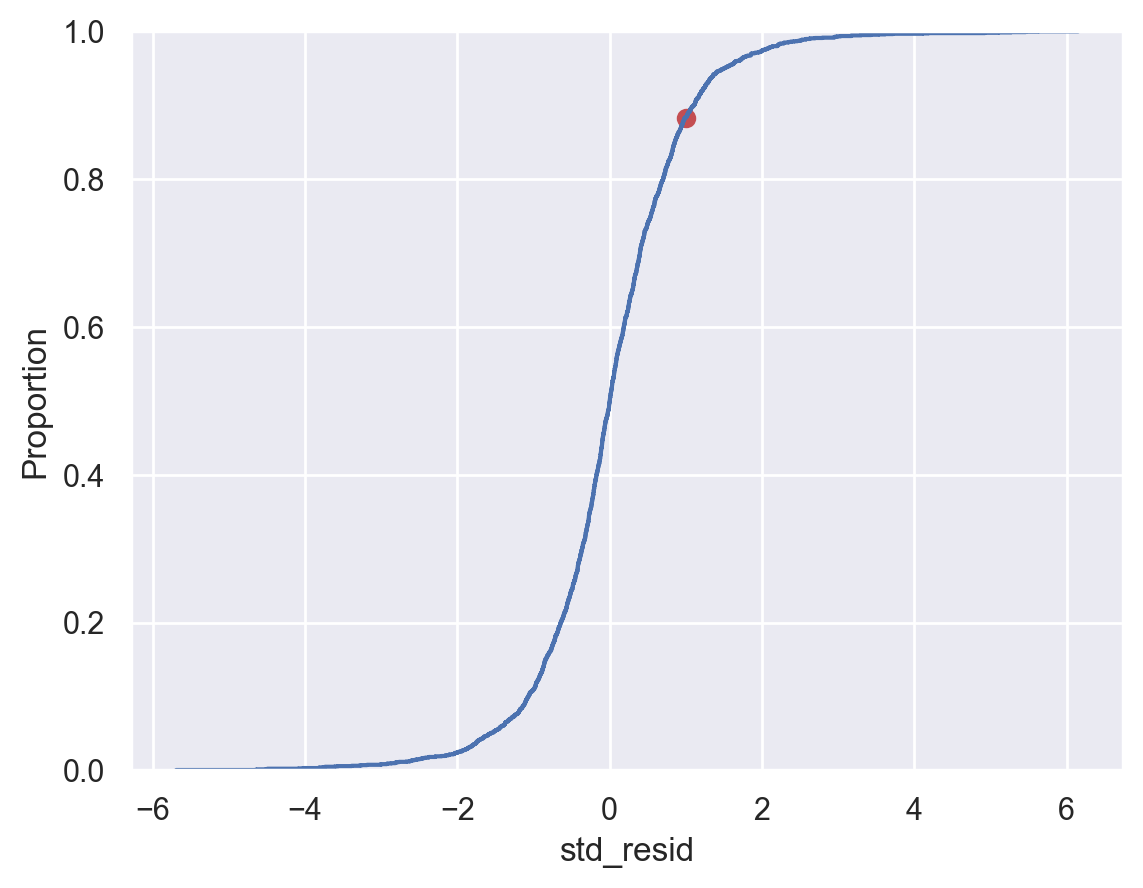

In [116]:
#check if the F_u is the correct value
sns.ecdfplot(res.std_resid)
plt.scatter(u, F_u, color='r')
plt.show()

### compute VaR

In [117]:
q95GPD = (u + ((beta/zeta) * ((((1-0.95)/(1-F_u))**(-zeta))  -1 )))
q99GPD = (u + ((beta/zeta) * ((((1-0.99)/(1-F_u))**(-zeta))  -1 )))

test_df['VaR95GPD'] = test_df['mus'] + test_df['sigmas']*q95GPD
test_df['VaR99GPD'] = test_df['mus'] + test_df['sigmas']*q99GPD

### compute ER

formula used slide 61, part 4
<br>
we used mus/sigmas from fitted GARCH(1,1) with Normal innovations as it is stated in part4, slide 53

In [118]:
test_df['ES95GPD'] = test_df['mus'] + test_df['sigmas']*((q95GPD/1-zeta)+((beta-zeta*u)/(1-zeta)))
test_df['ES99GPD'] = test_df['mus'] + test_df['sigmas']*((q99GPD/1-zeta)+((beta-zeta*u)/(1-zeta)))

In [119]:
beta

np.float64(0.5533943509053127)

In [120]:
test_df.head()

Date        TSLA  log_returns      loss       mus    sigmas  \
2268 2021-11-29  378.996674    -4.964716  4.964716  0.150609  3.766584   
2269 2021-11-30  381.586670    -0.681058  0.681058  0.150609  3.764631   
2270 2021-12-01  365.000000     4.444065 -4.444065  0.150609  3.762699   
2271 2021-12-02  361.533325     0.954313 -0.954313  0.150609  3.760787   
2272 2021-12-03  338.323334     6.635217 -6.635217  0.150609  3.758895   

         VaR95     VaR99      ES95       ES99      must   sigmast    VaR95t  \
2268  6.346088  8.912993  7.919990  10.189362  0.185897  3.878945  5.861372   
2269  6.342877  8.908452  7.915963  10.184159  0.185897  3.882575  5.866684   
2270  6.339699  8.903957  7.911977  10.179009  0.185897  3.886175  5.871951   
2271  6.336554  8.899508  7.908033  10.173912  0.185897  3.889743  5.877172   
2272  6.333441  8.895106  7.904129  10.168869  0.185897  3.893281  5.882348   

         VaR99t      ES95t      ES99t  VaR95GPD   VaR99GPD   ES95GPD  \
2268  10.498529  10.055982  12.108343  5.841246  10.471393  6.800507   
2269  10.508182  10.065220  12.119502  5.838296  10.466044  6.797061   
2270  10.517751  10.074379  12.130565  5.835377  10.460749  6.793649   
2271  10.527238  10.083459  12.141534  5.832488  10.455510  6.790273   
2272  10.536644  10.092462  12.152408  5.829629  10.450324  6.786932   

        ES99GPD  
2268  11.430655  
2269  11.424808  
2270  11.419021  
2271  11.413295  
2272  11.407627

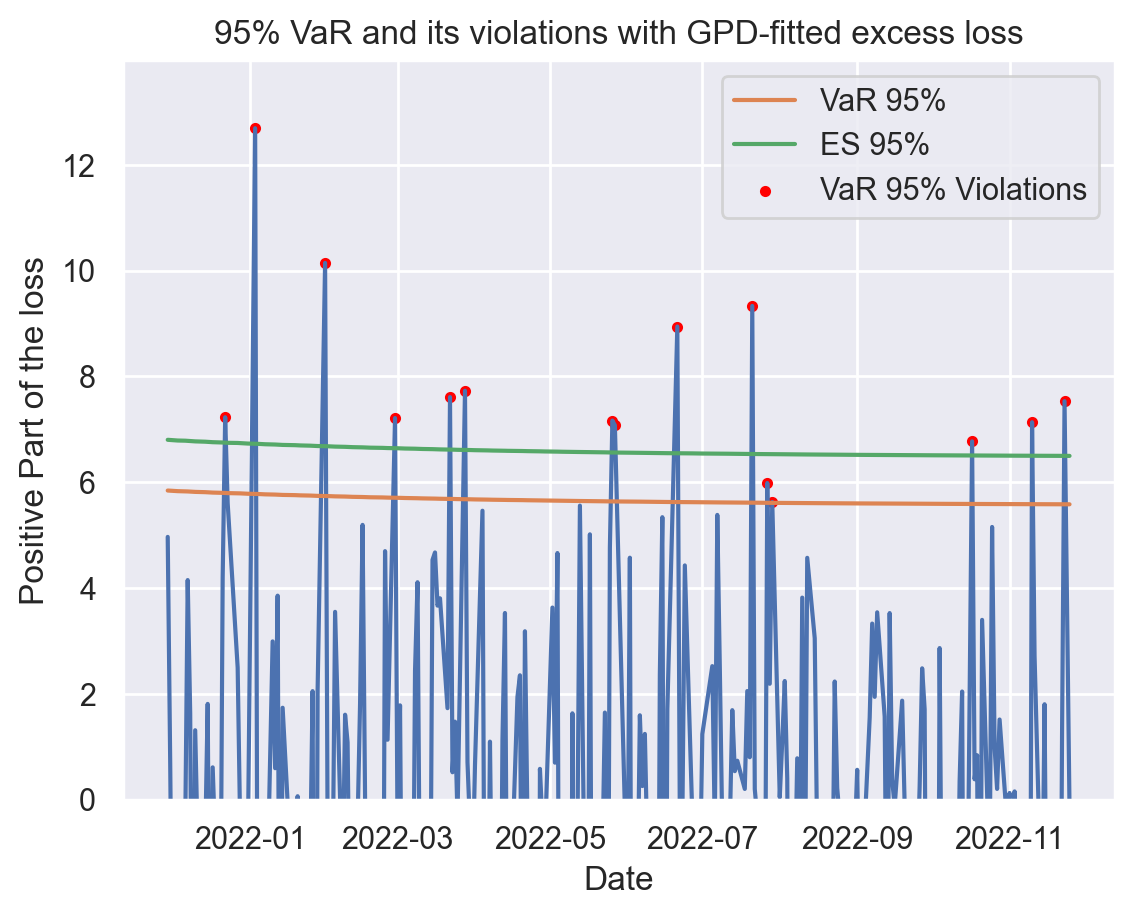

In [121]:
plt.plot(test_df.Date, test_df['loss'])
plt.plot(test_df.Date, test_df['VaR95GPD'], label='VaR 95%')
plt.plot(test_df.Date, test_df['ES95GPD'], label='ES 95%')
plt.ylim(0)
plt.ylabel('Positive Part of the loss')
plt.xlabel('Date')
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

violations = test_df[test_df['loss'] > test_df['VaR95GPD']]
plt.scatter(violations.Date, violations.loss, color='red', marker='.', label='VaR 95% Violations')
plt.legend()
plt.title('95% VaR and its violations with GPD-fitted excess loss')
plt.show()


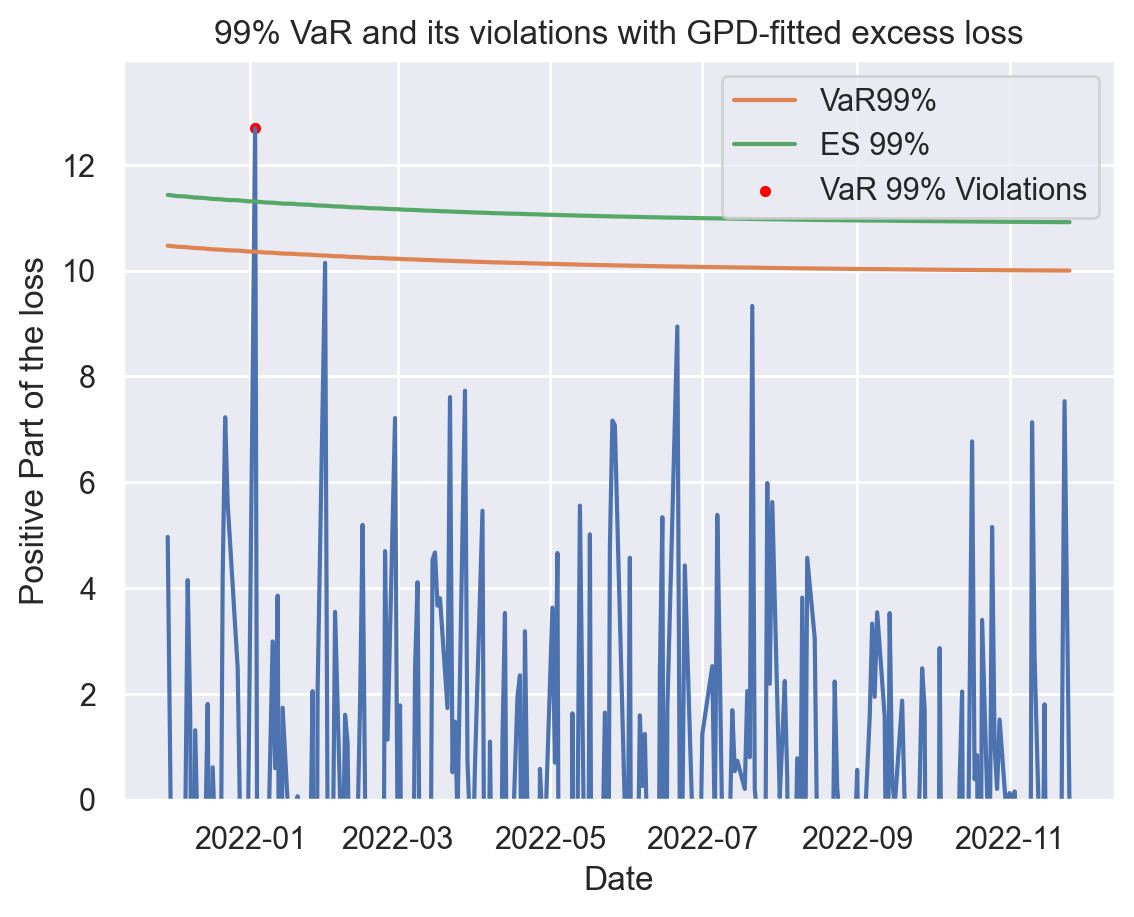

In [122]:
plt.plot(test_df.Date, test_df['loss'])
plt.plot(test_df.Date, test_df['VaR99GPD'], label='VaR99%')
plt.plot(test_df.Date, test_df['ES99GPD'], label='ES 99%')

plt.ylim(0)
plt.ylabel('Positive Part of the loss')
plt.xlabel('Date')
locator = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(locator)

violations = test_df[test_df['loss'] > test_df['VaR99GPD']]
plt.scatter(violations.Date, violations.loss, color='red', marker='.', label='VaR 99% Violations')
plt.legend()
plt.title('99% VaR and its violations with GPD-fitted excess loss')
plt.show()


## Backtesting VaR

In [123]:
from scipy.stats import chi2

def kupiec_test(actual_losses, var, alpha=0.05):
    """
    Kupiec's Unconditional Coverage Test (Proportion of Failures Test)
    
    Parameters:
    - actual_losses: array-like, les pertes réalisées
    - var: array-like, les valeurs de VaR correspondantes
    - alpha: float, niveau de confiance pour VaR (ex: 0.05 pour VaR 95%)
    
    Returns:
    - LRuc: statistique de test
    - p_value: p-value du test
    """
    actual_losses = np.array(actual_losses)
    var = np.array(var)
    
    n = len(actual_losses)
    x = np.sum(actual_losses > var) 
    # theoretical proba
    p = alpha
    # empirical exceedances frequency
    p_hat = x / n
    
    # Log-likelihood ratio
    if p_hat == 0 or p_hat == 1:
        LRuc = np.inf 
    else:
        LRuc = -2 * (np.log((1-p)**(n-x) * p**x) - np.log((1-p_hat)**(n-x) * p_hat**x))
    
    # p-value
    p_value = 1 - chi2.cdf(LRuc, df=1)
    
    return LRuc, p_value


In [124]:
for col in ['VaR95', 'VaR99', 'VaR95t', 'VaR99t', 'VaR95GPD', 'VaR99GPD']:
    LRuc, p_value = kupiec_test(test_df['loss'], test_df[col], alpha)
    print(f" for col {col}: LRuc: {LRuc:.4f}, p-value: {p_value:.4f}")


 for col VaR95: LRuc: 0.0168, p-value: 0.8969
 for col VaR99: LRuc: 8.2556, p-value: 0.0041
 for col VaR95t: LRuc: 0.0168, p-value: 0.8969
 for col VaR99t: LRuc: 18.5912, p-value: 0.0000
 for col VaR95GPD: LRuc: 0.4751, p-value: 0.4906
 for col VaR99GPD: LRuc: 18.5912, p-value: 0.0000


Kupiec tests rejects H0 for all VaR99%, this can be because we have too few samples, and thus, Kupiec test expects a very few violations, and even a few difference between theoretical expected violations and actual violations can generate high LRuc values, leading to rejecting H0, even if a model is acceptable.  